In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import argparse
import random
import os
import time 
from termcolor import colored
from scipy.io import loadmat

import sys
sys.path.append("../..")
from networks import *

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 9})
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")

import warnings
warnings.filterwarnings("ignore")

In [2]:
cluster = False
save = True

In [3]:
if cluster == True:
    parser = argparse.ArgumentParser()
    parser.add_argument('-seed', dest='seed', type=int, default=0, help='Seed number.')
    args = parser.parse_args()

    # Print all the arguments
    for arg in vars(args):
        print(f'{arg}: {getattr(args, arg)}')

    seed = args.seed
    
if cluster == False:
    seed = 0 # Seed number.

if save == True:
    resultdir = os.path.join(os.getcwd(), 'DeepONet_results', 'seed='+str(seed)) 
    if not os.path.exists(resultdir):
        os.makedirs(resultdir)

if save == True and cluster == True:
    orig_stdout = sys.stdout
    q = open(os.path.join(resultdir, 'output-'+'seed='+str(seed)+'.txt'), 'w')
    sys.stdout = q
    print ("------START------")

print('seed = '+str(seed))

seed = 0


In [4]:
start = time.time()
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
# Load the data
data = loadmat('data/Burger.mat') # Load the .mat file
#print(data)
print(data['tspan'].shape)
print(data['input'].shape)  # Initial conditions: Gaussian random fields, Nsamples x 101, each IC sample is (1 x 101)
print(data['output'].shape) # Time evolution of the solution field: Nsamples x 101 x 101.
                             # Each field is 101 x 101, rows correspond to time and columns respond to location.
                             # First row corresponds to solution at t=0 (1st time step)
                             # and next  row corresponds to solution at t=0.01 (2nd time step) and so on.
                             # last row correspond to solution at t=1 (101th time step).

(1, 101)
(2500, 101)
(2500, 101, 101)


In [7]:
# Convert NumPy arrays to PyTorch tensors
inputs = torch.from_numpy(data['input']).float().to(device)
outputs = torch.from_numpy(data['output']).float().to(device)

t_span = torch.from_numpy(data['tspan'].flatten()).float().to(device)
x_span = torch.linspace(0, 1, data['output'].shape[2]).float().to(device)
nt, nx = len(t_span), len(x_span) # number of discretizations in time and location.
print("nt =",nt, ", nx =",nx)
print("Shape of t-span and x-span:",t_span.shape, x_span.shape)
print("t-span:", t_span)
print("x-span:", x_span)

# Estimating grid points
T, X = torch.meshgrid(t_span, x_span)
# print(T)
# print(X)
grid = torch.vstack((T.flatten(), X.flatten())).T
print("Shape of grid:", grid.shape) # (nt*nx, 2)
print("grid:", grid) # time, location

# Split the data into training (2000) and testing (500) samples
inputs_train, inputs_test, outputs_train, outputs_test = train_test_split(inputs, outputs, test_size=500, random_state=seed)

# Check the shapes of the subsets
print("Shape of inputs_train:", inputs_train.shape)
print("Shape of inputs_test:", inputs_test.shape)
print("Shape of outputs_train:", outputs_train.shape)
print("Shape of outputs_test:", outputs_test.shape)
print('#'*100)

nt = 101 , nx = 101
Shape of t-span and x-span: torch.Size([101]) torch.Size([101])
t-span: tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
        0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
        0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
        0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
        0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
        0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
        0.9900, 1.0000])
x-s

In [8]:
class DeepONet(nn.Module):

    def __init__(self, branch_net, trunk_net):
        super().__init__()
        
        self.branch_net = branch_net
        self.trunk_net = trunk_net
    
    def forward(self, branch_inputs, trunk_inputs):
        """
        bs    :  Batch size.
        m     :  Number of sensors on each input IC field. # IC:initial condition
        neval :  Number of points at which output field is evaluated for a given input IC field sample = nt*nx
        p     :  Number of output neurons in both branch and trunk net.   
        
        branch inputs shape: (bs, m) 
        trunk inputs shape : (neval, 2) # 2 corresponds to t and x
        
        shapes:  inputs shape         -->      outputs shape
        branch:  (bs x m)             -->      (bs x p)
        trunk:   (neval x 2)          -->      (neval x p)
        
        outputs shape: (bs x neval).
        """
        
        branch_outputs = self.branch_net(branch_inputs)
        trunk_outputs = self.trunk_net(trunk_inputs)
        
        results = torch.einsum('ik, lk -> il', branch_outputs, trunk_outputs)
        
        return results

In [9]:
class Sin(nn.Module):
    def __init__(self):
        super(Sin, self).__init__()

    def forward(self, x):
        return torch.sin(x)

In [10]:
"""
input_neurons_branch: Number of input neurons in the branch net.
input_neurons_trunk: Number of input neurons in the trunk net.
p: Number of output neurons in both the branch and trunk net.
"""
p = 100 # Number of output neurons in both the branch and trunk net.

input_neurons_branch = nx # m
branch_net = DenseNet(layersizes=[input_neurons_branch] + [100]*6 + [p], activation=nn.SiLU()) #nn.LeakyReLU() #nn.Tanh()
branch_net.to(device)
# print(branch_net)
print('BRANCH-NET SUMMARY:')
summary(branch_net, input_size=(input_neurons_branch,))  
print('#'*100)

# 2 corresponds to t and x
input_neurons_trunk = 2
trunk_net = DenseNet(layersizes=[input_neurons_trunk] + [100]*6 + [p], activation=nn.SiLU()) #nn.LeakyReLU() #nn.Tanh()
trunk_net.to(device)
# print(trunk_net)
print('TRUNK-NET SUMMARY:')
summary(trunk_net, input_size=(input_neurons_trunk,))
print('#'*100)

model = DeepONet(branch_net, trunk_net)
model.to(device)

BRANCH-NET SUMMARY:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          10,200
              SiLU-2                  [-1, 100]               0
            Linear-3                  [-1, 100]          10,100
              SiLU-4                  [-1, 100]               0
            Linear-5                  [-1, 100]          10,100
              SiLU-6                  [-1, 100]               0
            Linear-7                  [-1, 100]          10,100
              SiLU-8                  [-1, 100]               0
            Linear-9                  [-1, 100]          10,100
             SiLU-10                  [-1, 100]               0
           Linear-11                  [-1, 100]          10,100
             SiLU-12                  [-1, 100]               0
           Linear-13                  [-1, 100]          10,100
Total params: 70,80

DeepONet(
  (branch_net): DenseNet(
    (activation): SiLU()
    (layers): ModuleList(
      (0): Linear(in_features=101, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): Linear(in_features=100, out_features=100, bias=True)
      (5): Linear(in_features=100, out_features=100, bias=True)
      (6): Linear(in_features=100, out_features=100, bias=True)
    )
  )
  (trunk_net): DenseNet(
    (activation): SiLU()
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): Linear(in_features=100, out_features=100, bias=True)
      (5): Linear(in_features=100, out_features=100, bias=Tru

In [11]:
def count_learnable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_learnable_parameters = count_learnable_parameters(branch_net) + count_learnable_parameters(trunk_net)
print("Total number of learnable parameters:", num_learnable_parameters)

Total number of learnable parameters: 131700


In [12]:
print('Shape of train data')
print(inputs_train.shape, outputs_train.shape)
print('#'*100)

bs = 64 # Batch size
# Calculate the number of batches
num_batches = len(inputs_train) // bs
# print("Number of batches:", num_batches)
        
# Training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=16000, gamma=1.0) # gamma=0.8

iteration_list, loss_list, learningrates_list = [], [], []
iteration = 0

n_epochs = 800 # 10 # 2000
for epoch in range(n_epochs):
    
    # Shuffle the train data using the generated indices
    num_samples = len(inputs_train)
    indices = torch.randperm(num_samples).to(device) # Generate random permutation of indices
    inputs_train_shuffled = inputs_train[indices]
    outputs_train_shuffled = outputs_train[indices]
    
    # Initialize lists to store batches
    inputs_train_batches = []
    outputs_train_batches = []
    # Split the data into batches
    for i in range(num_batches):
        start_idx = i * bs
        end_idx = (i + 1) * bs
        inputs_train_batches.append(inputs_train_shuffled[start_idx:end_idx])
        outputs_train_batches.append(outputs_train_shuffled[start_idx:end_idx])
    # Handle leftover data into the last batch
    if len(inputs_train_shuffled) % bs != 0:
        start_idx = num_batches * bs
        inputs_train_batches.append(inputs_train_shuffled[start_idx:])
        outputs_train_batches.append(outputs_train_shuffled[start_idx:])
    
    for i, (inputs_batch, outputs_batch) in enumerate(zip(inputs_train_batches, outputs_train_batches)):
        #print(f"Shape of inputs_train_batch[{i}]:", inputs_batch.shape) # (bs, nx)
        #print(f"Shape of outputs_train_batch[{i}]:", outputs_batch.shape) # (bs, nt, nx)
        
        branch_inputs = inputs_batch # (bs, m) = (bs, nx) 
        
        trunk_inputs = grid # (neval, 2) = (nt*nx, 2)
            
        outputs_needed = outputs_batch.reshape(-1, nt*nx) # (bs, neval) = (bs, nt*nx)

        # print(branch_inputs.shape, trunk_inputs.shape, outputs_needed.shape)   
        # print('*********')

        optimizer.zero_grad()
        predicted_values = model(branch_inputs, trunk_inputs) # (bs, nt*nx)
        target_values = outputs_needed # (bs, nt*nx)
        loss = nn.MSELoss()(predicted_values, target_values)
        loss.backward()
        # torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()
        scheduler.step()
        
        if epoch % 100 == 0:
            print('Epoch %s:' % epoch, 'Batch %s:' % i, 'loss = %f,' % loss,
                  'learning rate = %f' % optimizer.state_dict()['param_groups'][0]['lr']) 
        
        iteration_list.append(iteration)
        loss_list.append(loss.item())
        learningrates_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        iteration+=1
    
if save == True:
    np.save(os.path.join(resultdir,'iteration_list.npy'), np.asarray(iteration_list))
    np.save(os.path.join(resultdir,'loss_list.npy'), np.asarray(loss_list))
    np.save(os.path.join(resultdir,'learningrates_list.npy'), np.asarray(learningrates_list))
    
plt.figure()
plt.plot(iteration_list, loss_list, 'g', label = 'training loss')
plt.yscale("log")
plt.xlabel('Iterations')
plt.ylabel('Training loss')
plt.legend()
plt.tight_layout()
if save == True:
    plt.savefig(os.path.join(resultdir,'loss_plot.pdf'))

plt.figure()
plt.plot(iteration_list, learningrates_list, 'b', label = 'learning-rate')
plt.xlabel('Iterations')
plt.ylabel('Learning-rate')
plt.legend()
plt.tight_layout()
if save == True:
    plt.savefig(os.path.join(resultdir,'learning-rate_plot.pdf'))
    
# end timer
finish = time.time() - start  # time for network to train

Shape of train data
torch.Size([2000, 101]) torch.Size([2000, 101, 101])
####################################################################################################
Epoch 0: Batch 0: loss = 0.030304, learning rate = 0.001000
Epoch 0: Batch 1: loss = 0.027340, learning rate = 0.001000
Epoch 0: Batch 2: loss = 0.023823, learning rate = 0.001000
Epoch 0: Batch 3: loss = 0.029220, learning rate = 0.001000
Epoch 0: Batch 4: loss = 0.035305, learning rate = 0.001000
Epoch 0: Batch 5: loss = 0.036323, learning rate = 0.001000
Epoch 0: Batch 6: loss = 0.033155, learning rate = 0.001000
Epoch 0: Batch 7: loss = 0.027104, learning rate = 0.001000
Epoch 0: Batch 8: loss = 0.028082, learning rate = 0.001000
Epoch 0: Batch 9: loss = 0.029884, learning rate = 0.001000
Epoch 0: Batch 10: loss = 0.035325, learning rate = 0.001000
Epoch 0: Batch 11: loss = 0.031382, learning rate = 0.001000
Epoch 0: Batch 12: loss = 0.024084, learning rate = 0.001000
Epoch 0: Batch 13: loss = 0.025192, learnin

In [ ]:
if save == True:
    torch.save(model.state_dict(), os.path.join(resultdir,'model_state_dict.pt'))
# model.load_state_dict(torch.load(os.path.join(resultdir,'model_state_dict.pt')))

TEST SAMPLE 10
Rel. L2 Error = 0.0249, R2 score = 0.9994


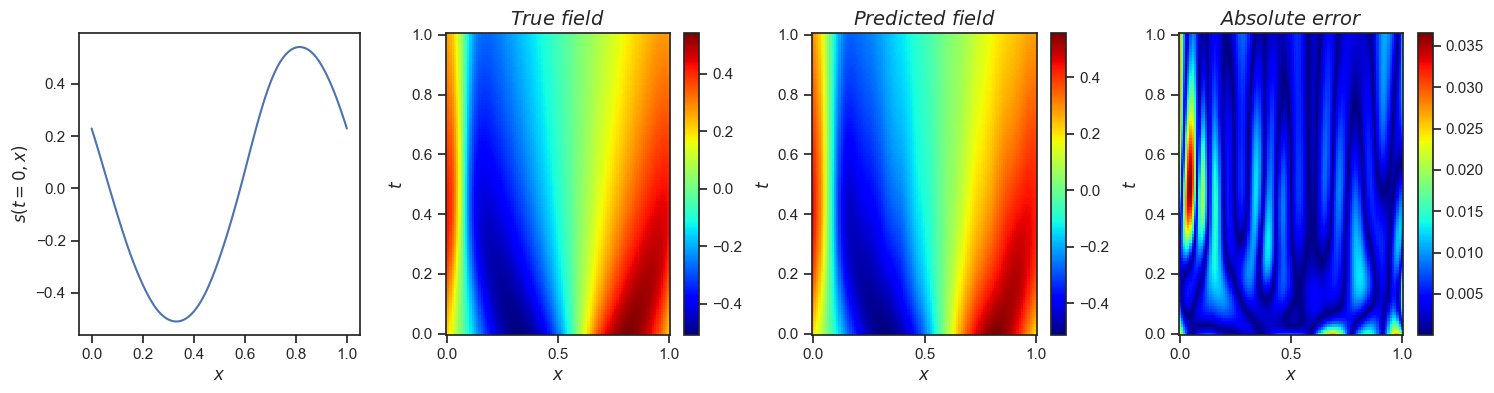

######################################################################################################################################################################################################################################
TEST SAMPLE 20
Rel. L2 Error = 0.0212, R2 score = 0.9996


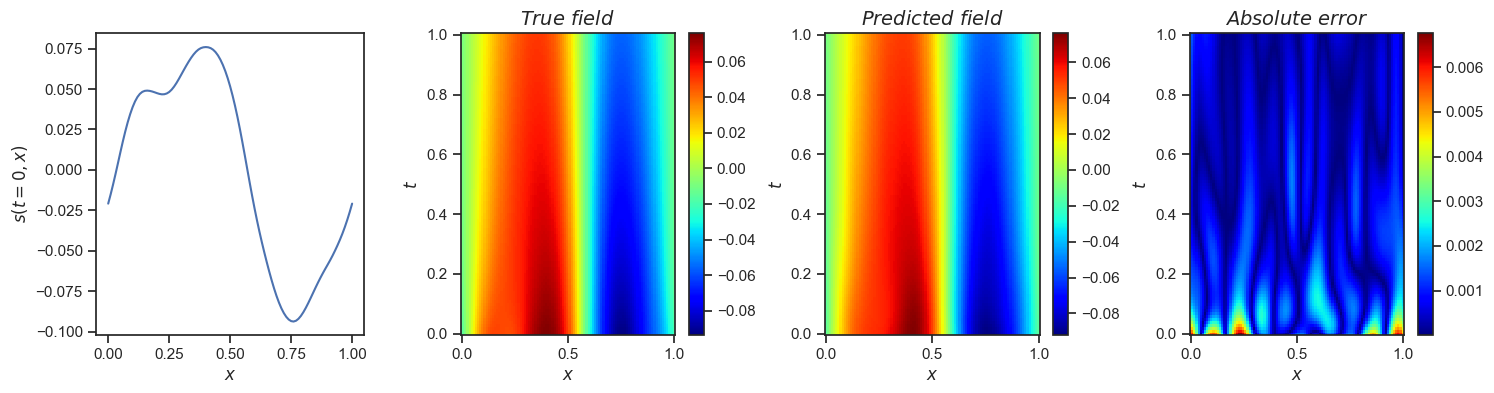

######################################################################################################################################################################################################################################
TEST SAMPLE 30
Rel. L2 Error = 0.0118, R2 score = 0.9999


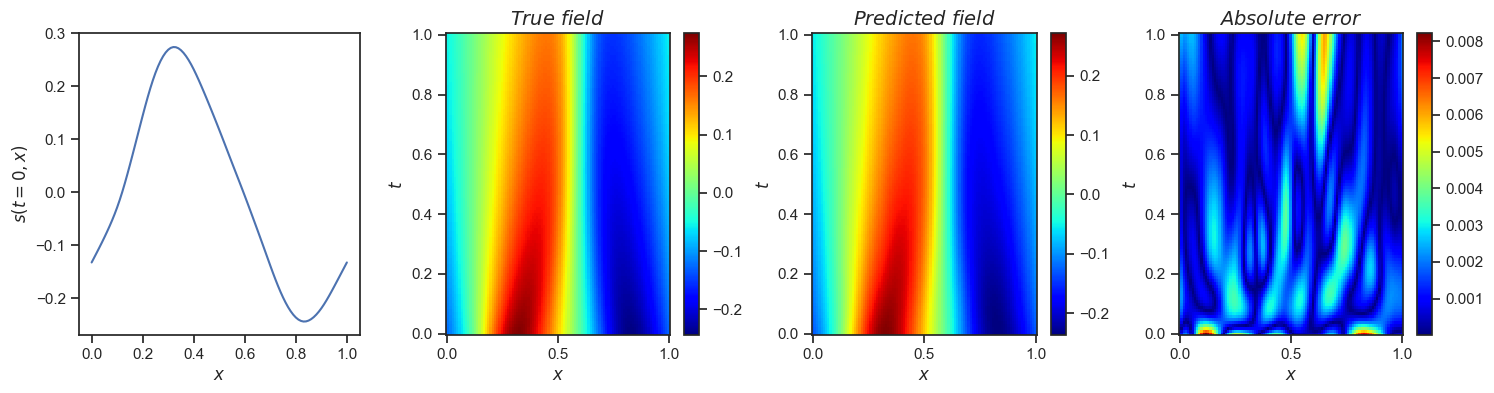

######################################################################################################################################################################################################################################
TEST SAMPLE 40
Rel. L2 Error = 0.0111, R2 score = 0.9999


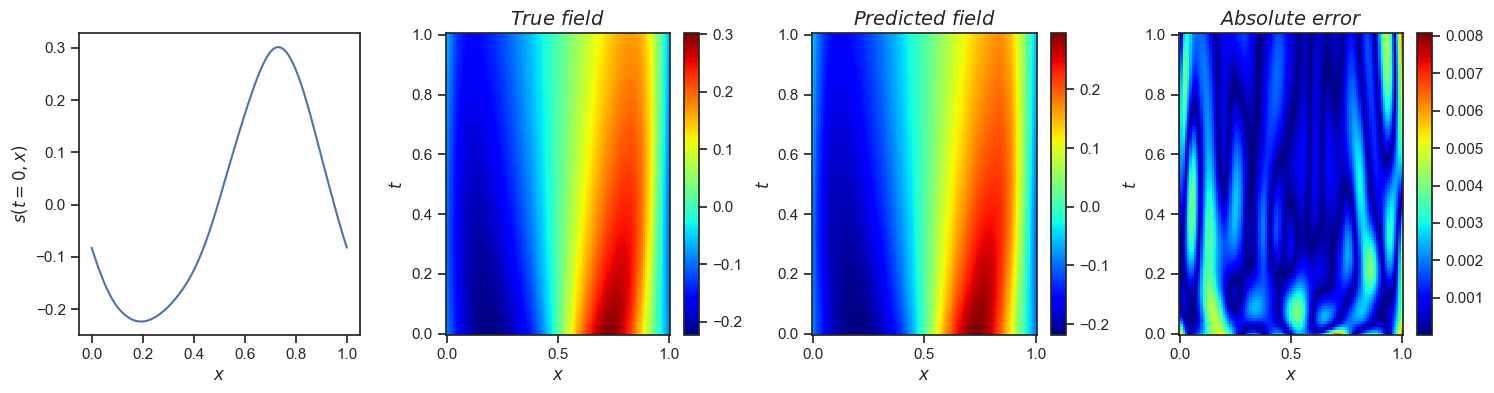

######################################################################################################################################################################################################################################
TEST SAMPLE 50
Rel. L2 Error = 0.0376, R2 score = 0.9986


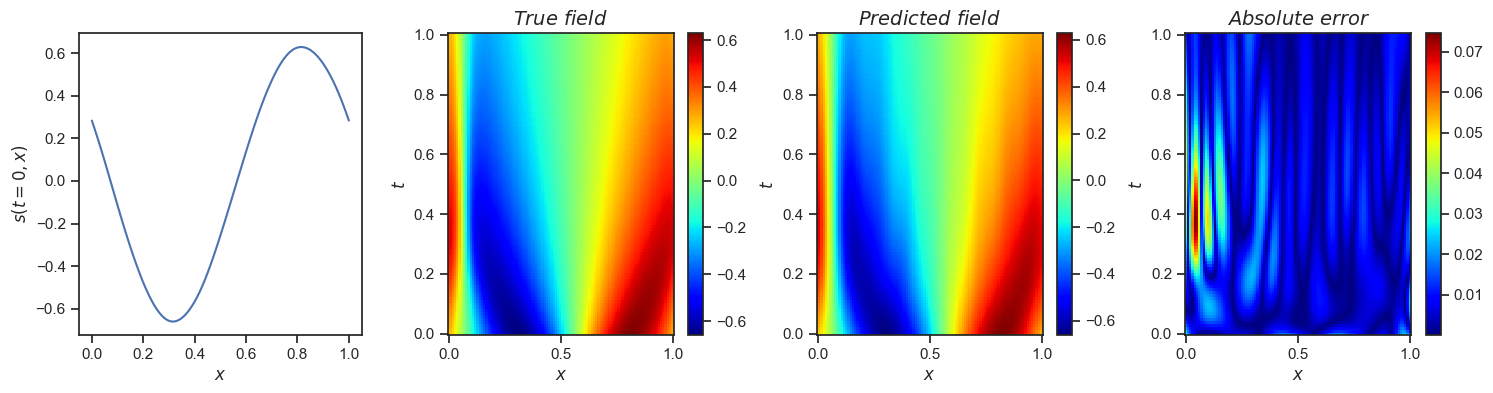

######################################################################################################################################################################################################################################
TEST SAMPLE 60
Rel. L2 Error = 0.0103, R2 score = 0.9999


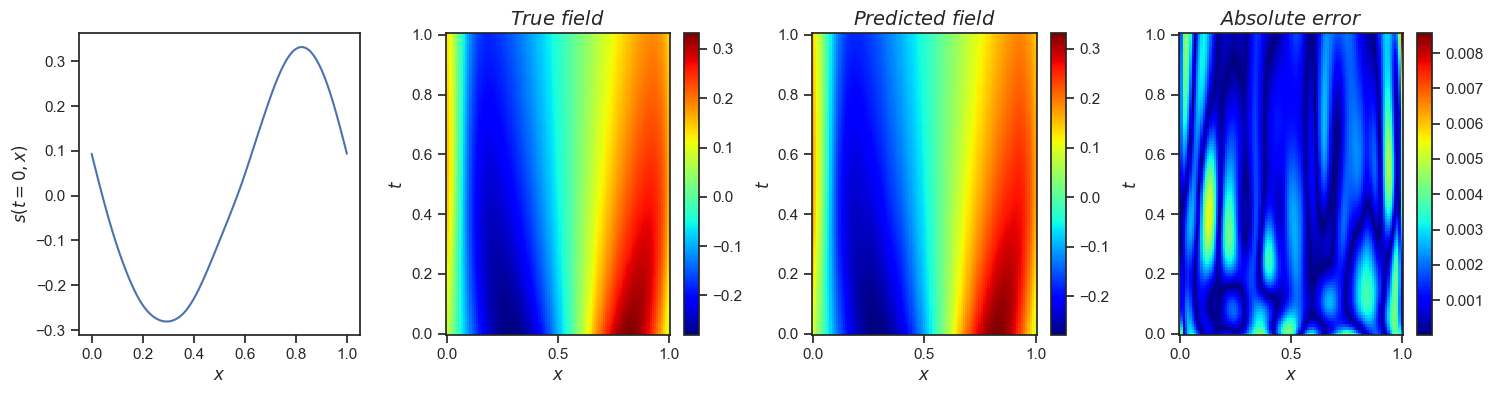

######################################################################################################################################################################################################################################
TEST SAMPLE 70
Rel. L2 Error = 0.0178, R2 score = 0.9997


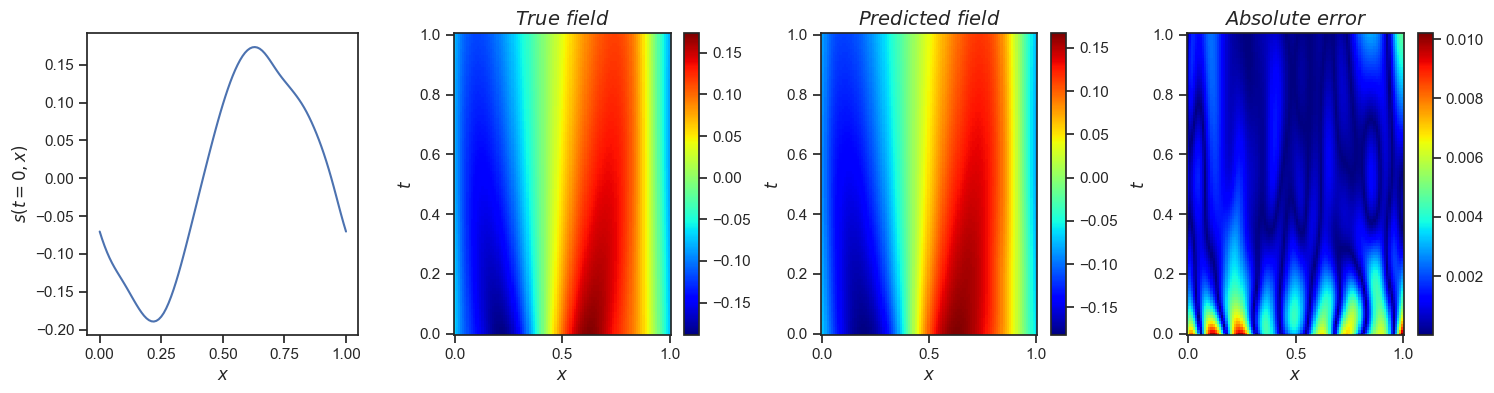

######################################################################################################################################################################################################################################
TEST SAMPLE 80
Rel. L2 Error = 0.0114, R2 score = 0.9999


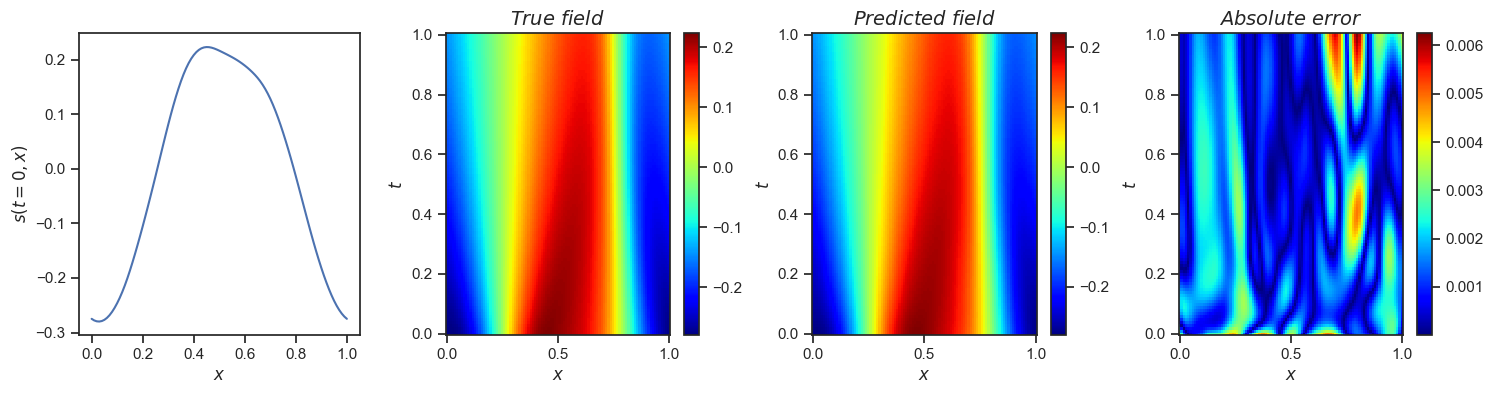

######################################################################################################################################################################################################################################
TEST SAMPLE 90
Rel. L2 Error = 0.0118, R2 score = 0.9999


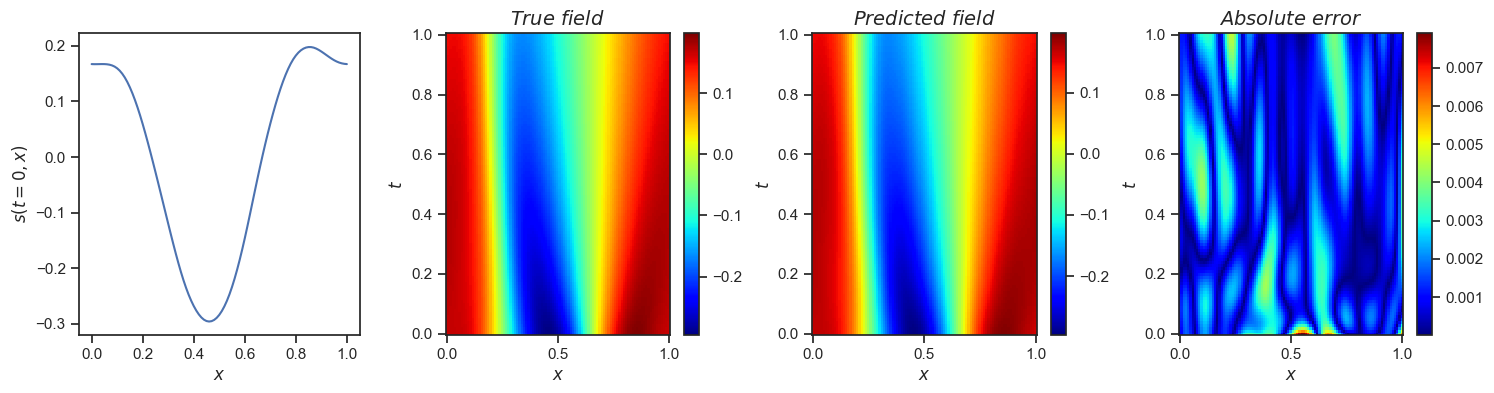

######################################################################################################################################################################################################################################
TEST SAMPLE 100
Rel. L2 Error = 0.0124, R2 score = 0.9998


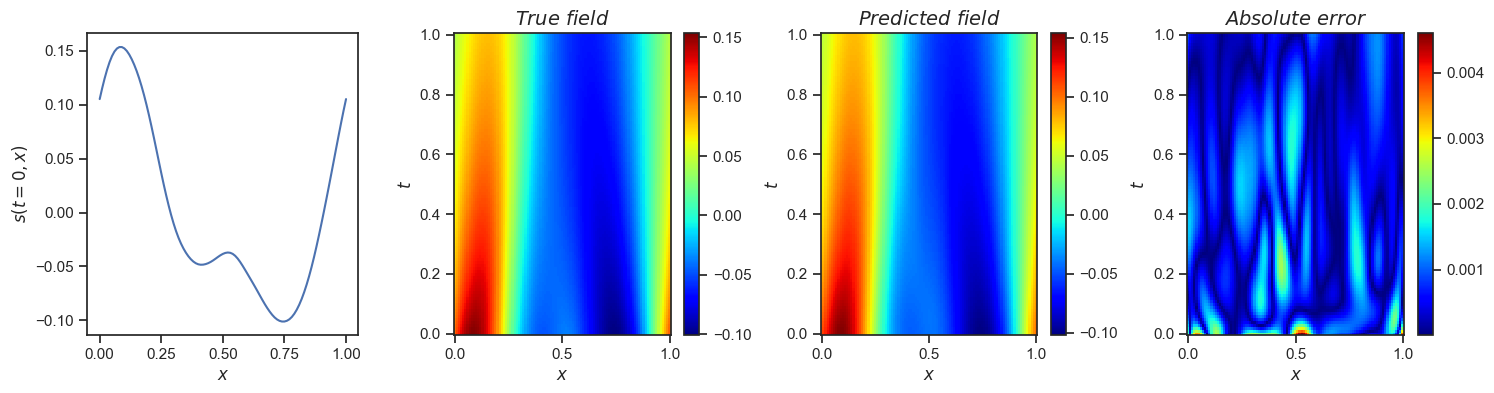

######################################################################################################################################################################################################################################
TEST SAMPLE 110
Rel. L2 Error = 0.0137, R2 score = 0.9998


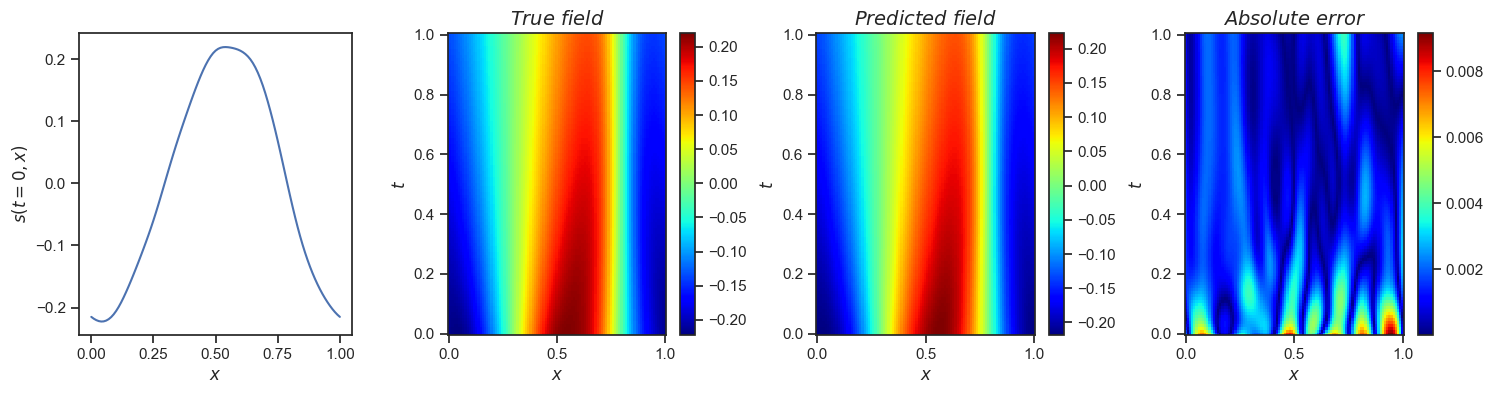

######################################################################################################################################################################################################################################
TEST SAMPLE 120
Rel. L2 Error = 0.0225, R2 score = 0.9995


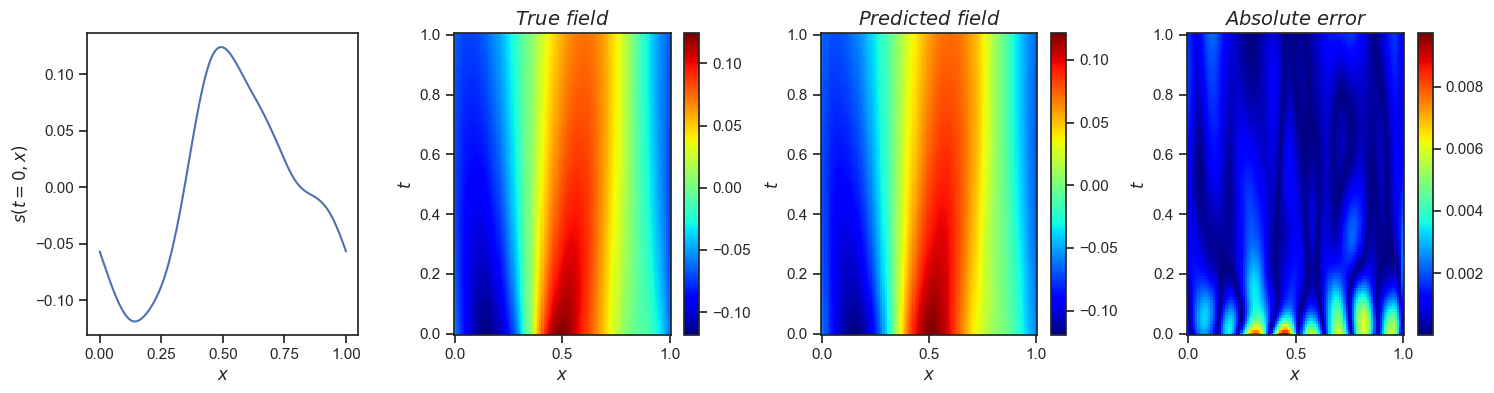

######################################################################################################################################################################################################################################
TEST SAMPLE 130
Rel. L2 Error = 0.0148, R2 score = 0.9998


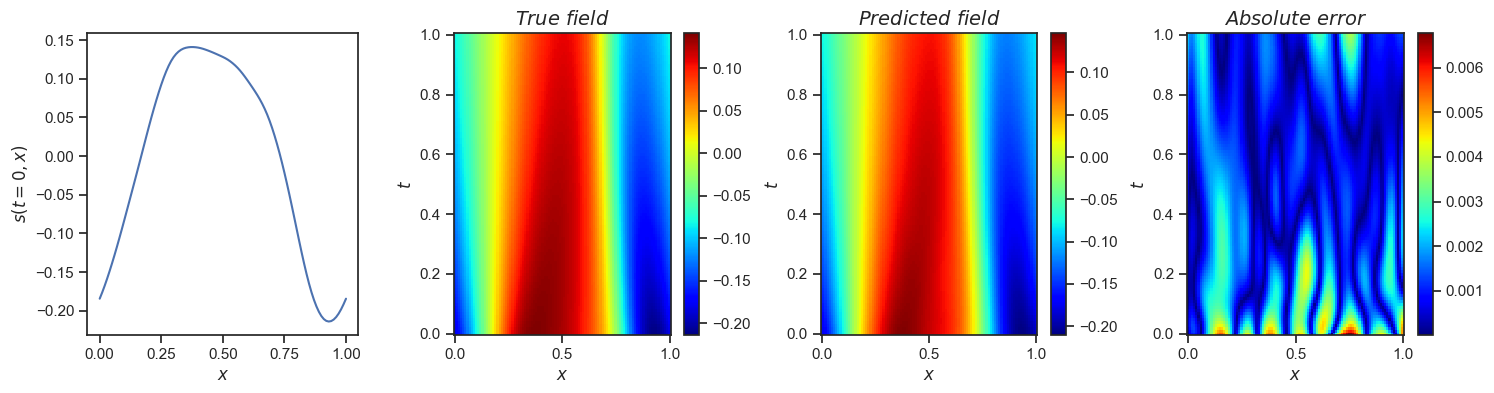

######################################################################################################################################################################################################################################
TEST SAMPLE 140
Rel. L2 Error = 0.0225, R2 score = 0.9995


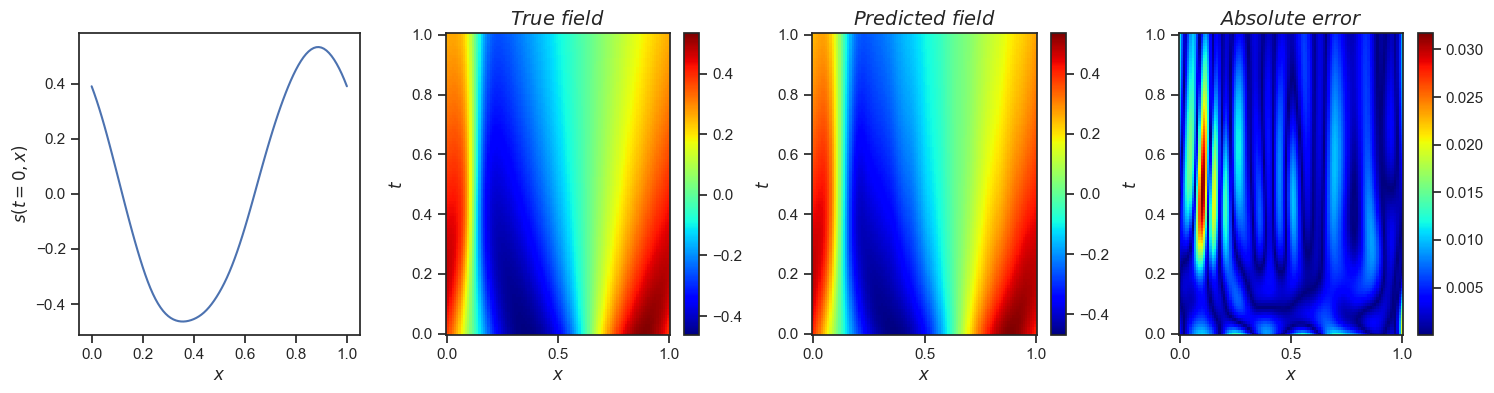

######################################################################################################################################################################################################################################
TEST SAMPLE 150
Rel. L2 Error = 0.0127, R2 score = 0.9998


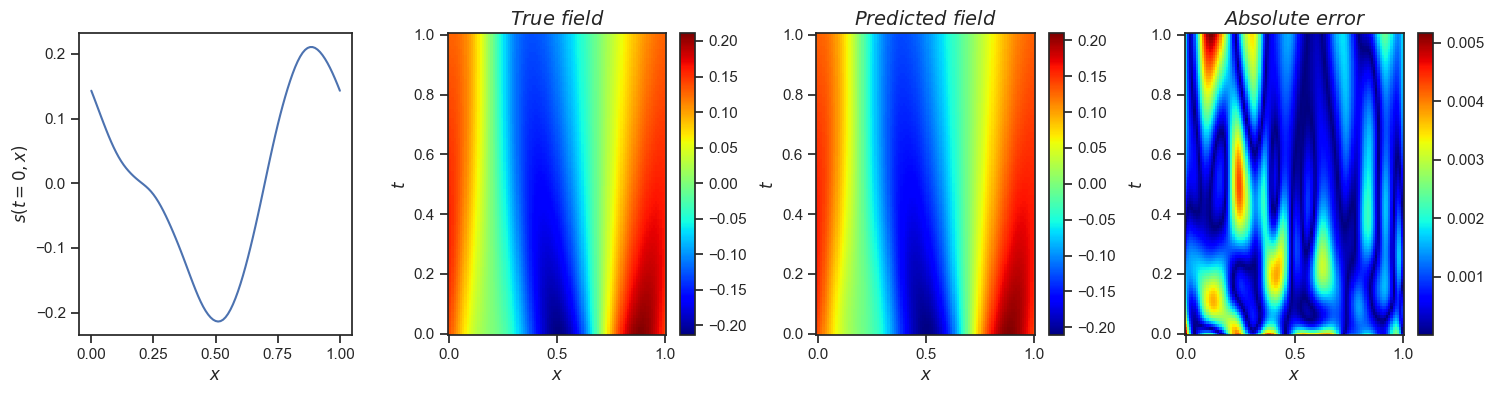

######################################################################################################################################################################################################################################
TEST SAMPLE 160
Rel. L2 Error = 0.0343, R2 score = 0.9988


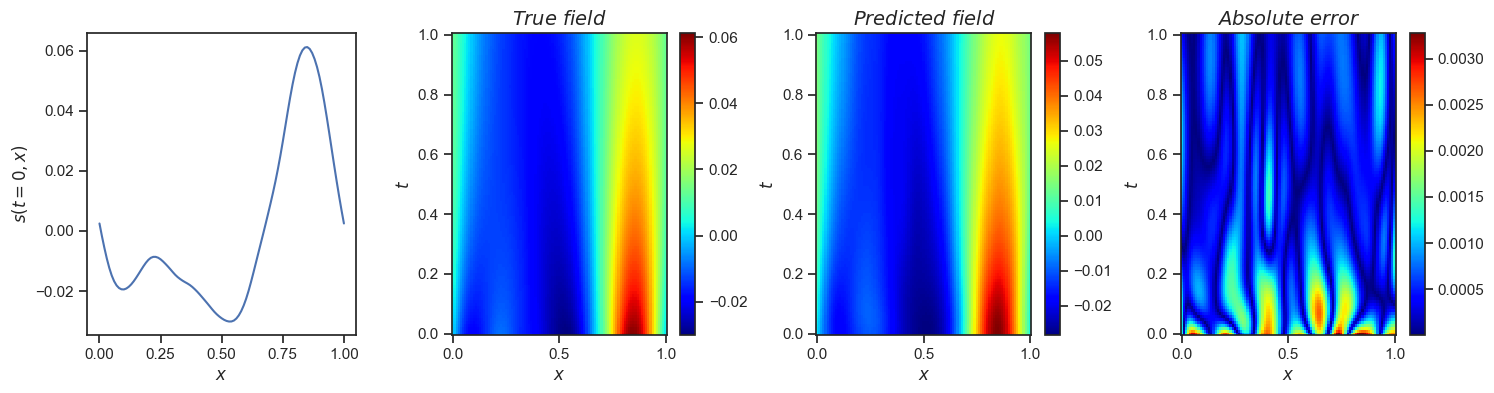

######################################################################################################################################################################################################################################
TEST SAMPLE 170
Rel. L2 Error = 0.0119, R2 score = 0.9999


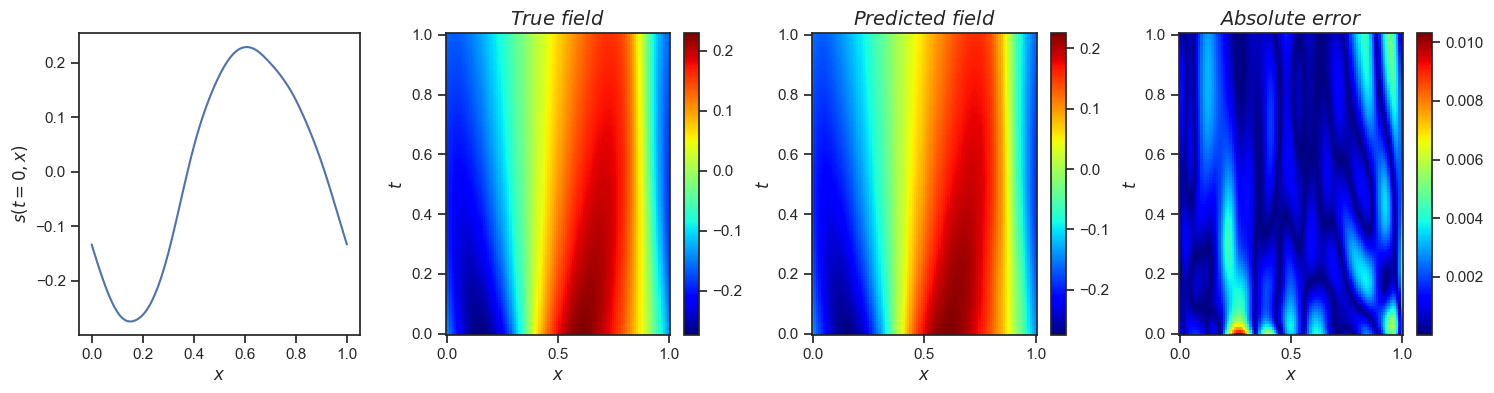

######################################################################################################################################################################################################################################
TEST SAMPLE 180
Rel. L2 Error = 0.0227, R2 score = 0.9995


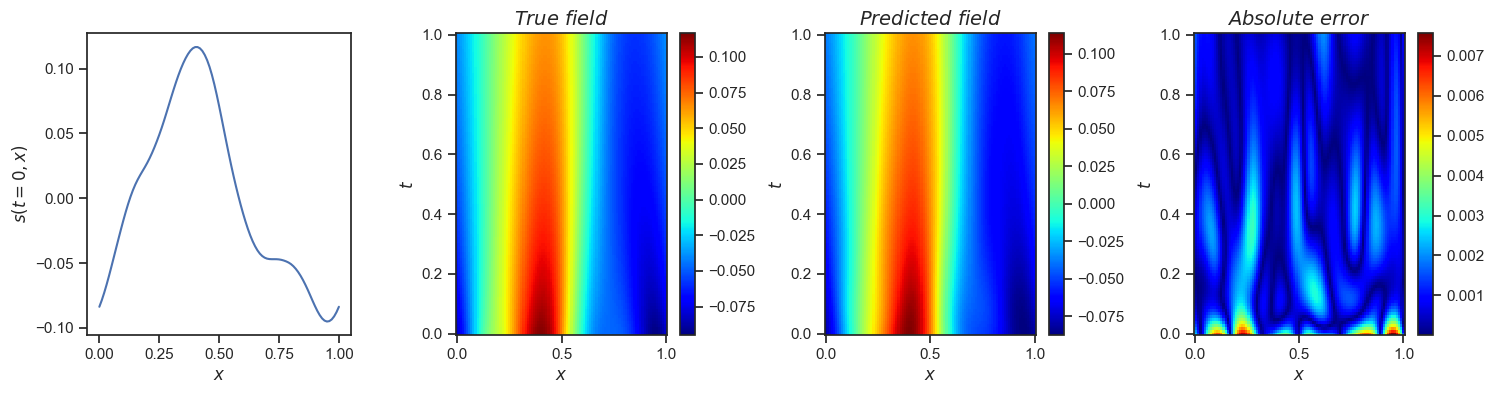

######################################################################################################################################################################################################################################
TEST SAMPLE 190
Rel. L2 Error = 0.0238, R2 score = 0.9994


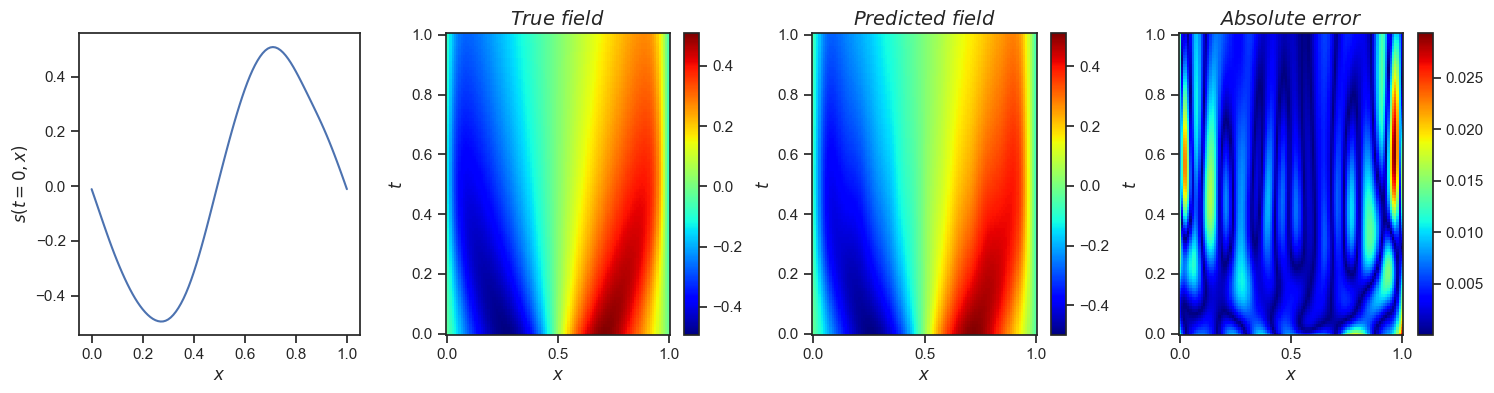

######################################################################################################################################################################################################################################
TEST SAMPLE 200
Rel. L2 Error = 0.018, R2 score = 0.9997


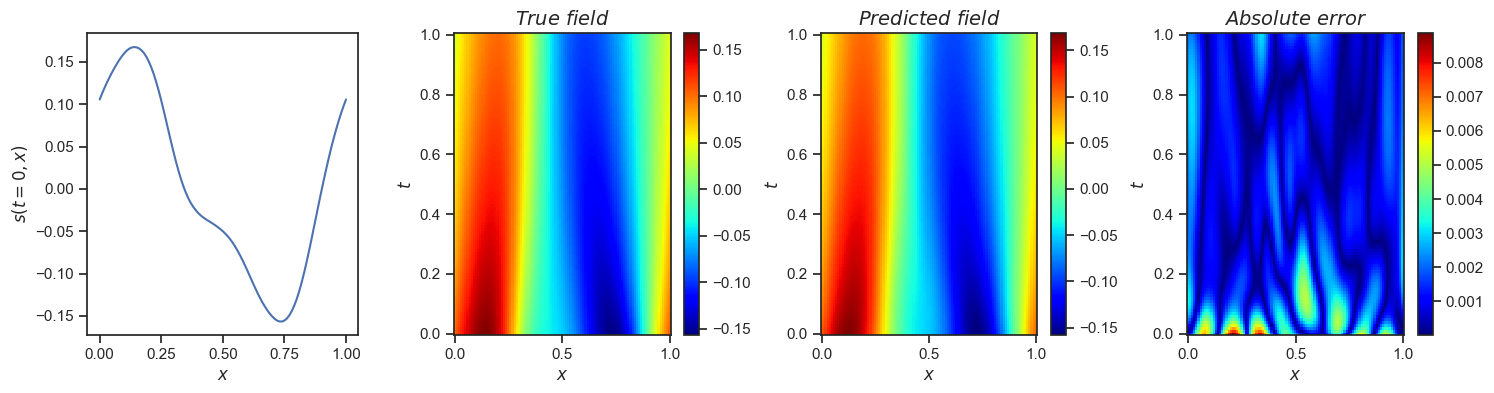

######################################################################################################################################################################################################################################
TEST SAMPLE 210
Rel. L2 Error = 0.0234, R2 score = 0.9995


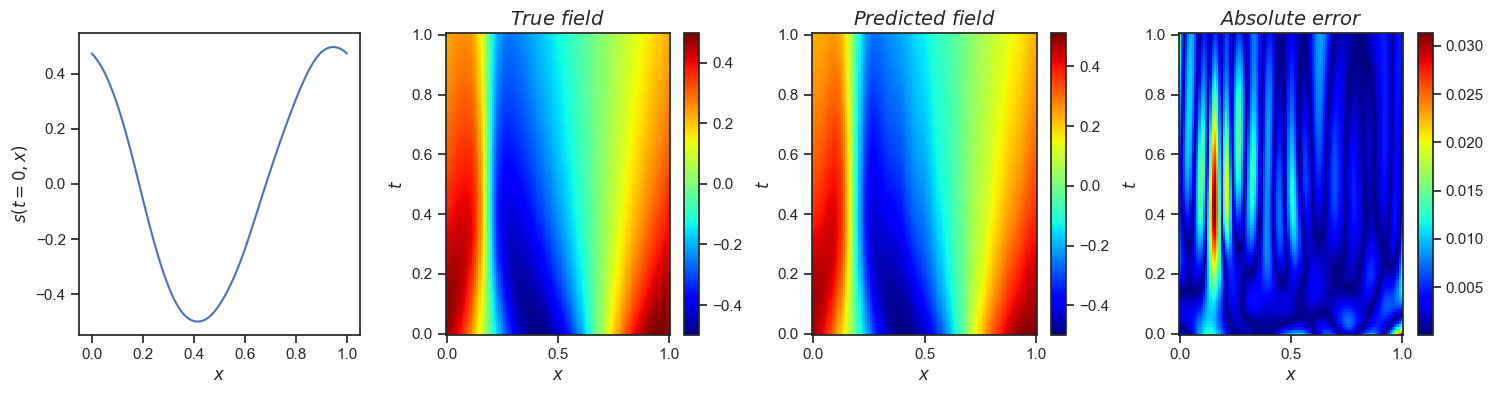

######################################################################################################################################################################################################################################
TEST SAMPLE 220
Rel. L2 Error = 0.0146, R2 score = 0.9998


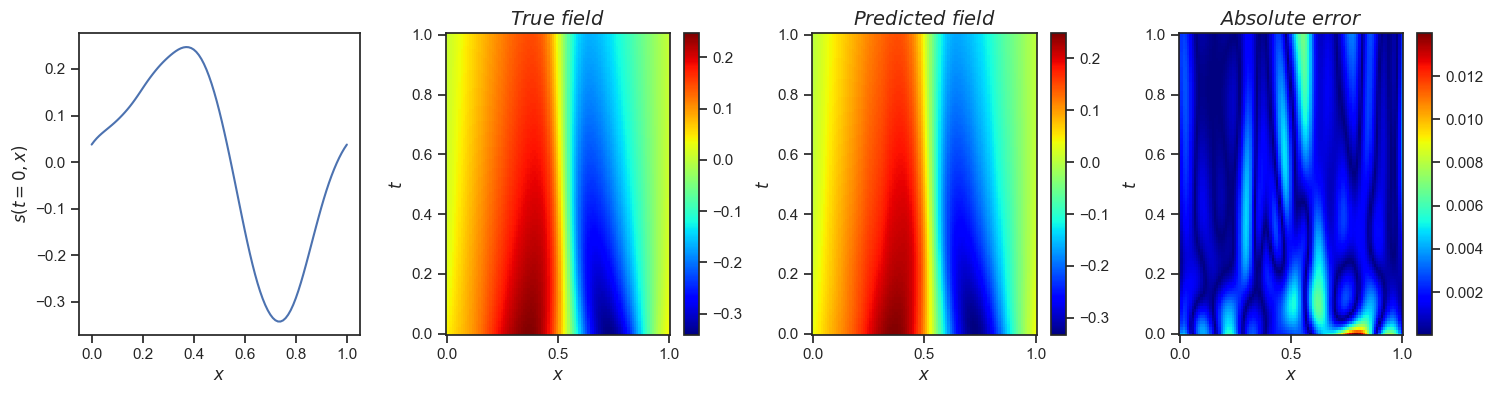

######################################################################################################################################################################################################################################
TEST SAMPLE 230
Rel. L2 Error = 0.0199, R2 score = 0.9996


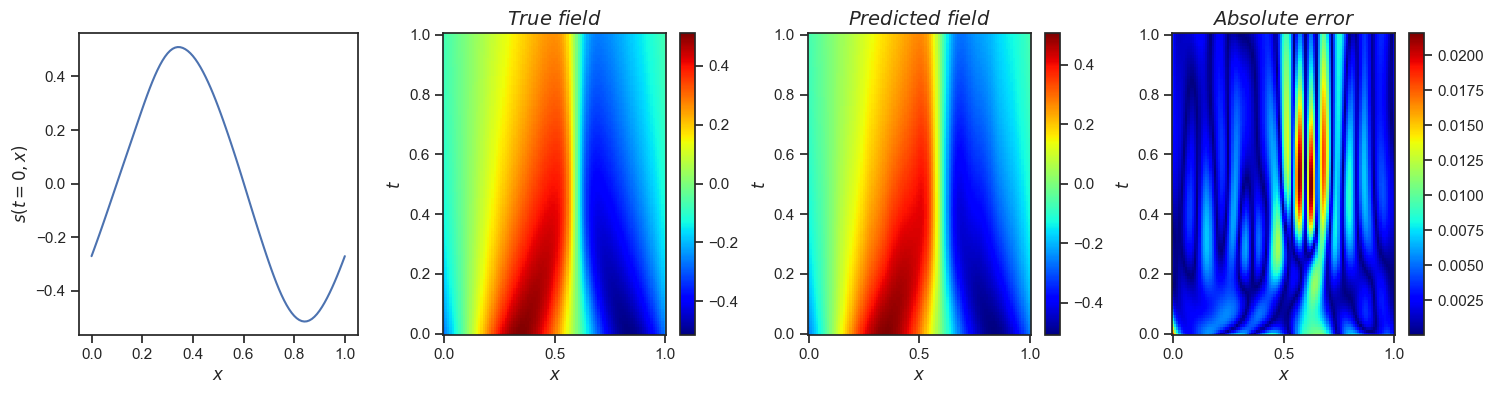

######################################################################################################################################################################################################################################
TEST SAMPLE 240
Rel. L2 Error = 0.011, R2 score = 0.9999


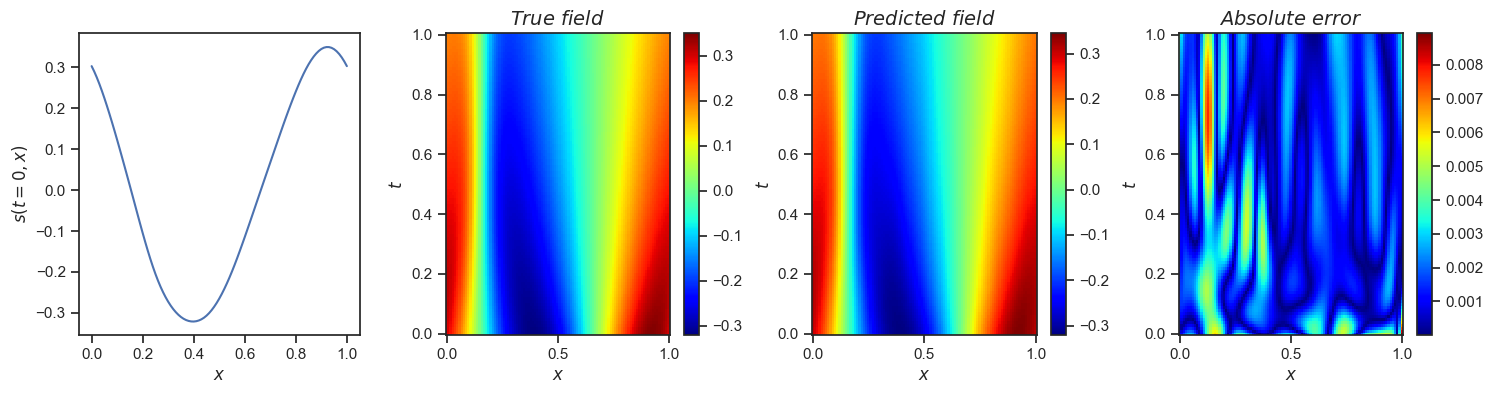

######################################################################################################################################################################################################################################
TEST SAMPLE 250
Rel. L2 Error = 0.0127, R2 score = 0.9998


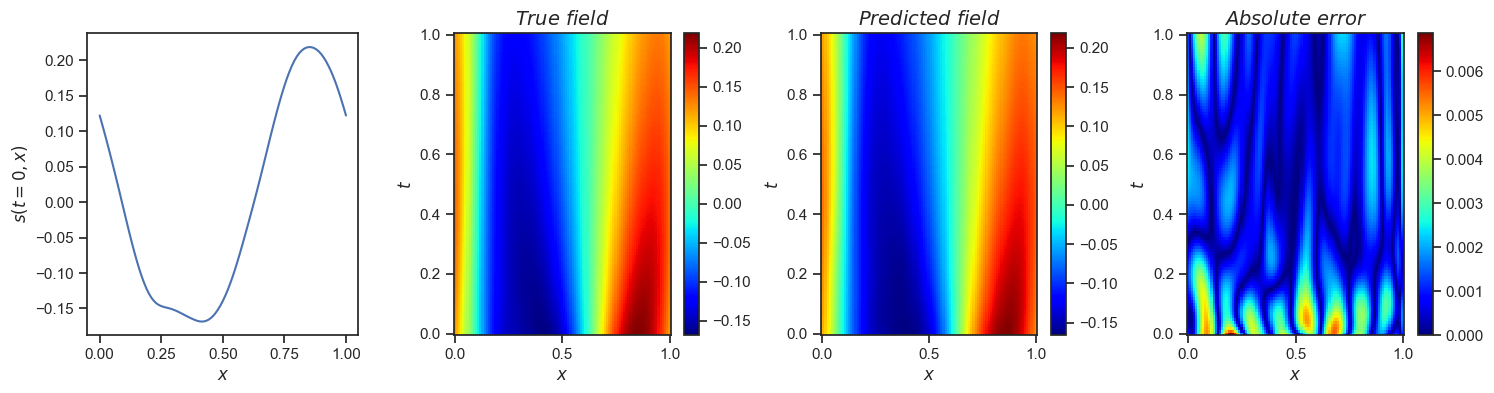

######################################################################################################################################################################################################################################
TEST SAMPLE 260
Rel. L2 Error = 0.0129, R2 score = 0.9998


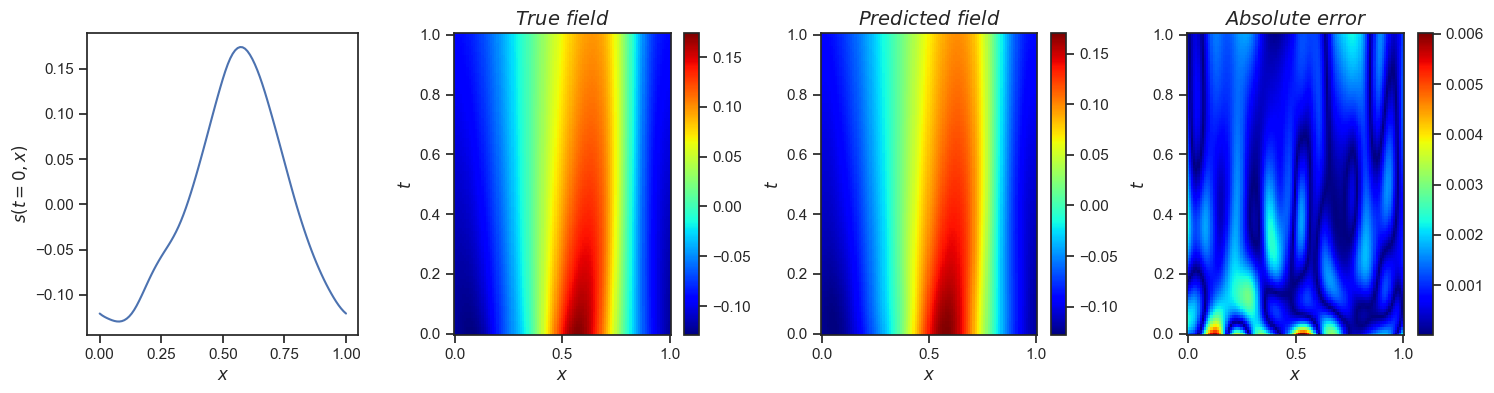

######################################################################################################################################################################################################################################
TEST SAMPLE 270
Rel. L2 Error = 0.0132, R2 score = 0.9998


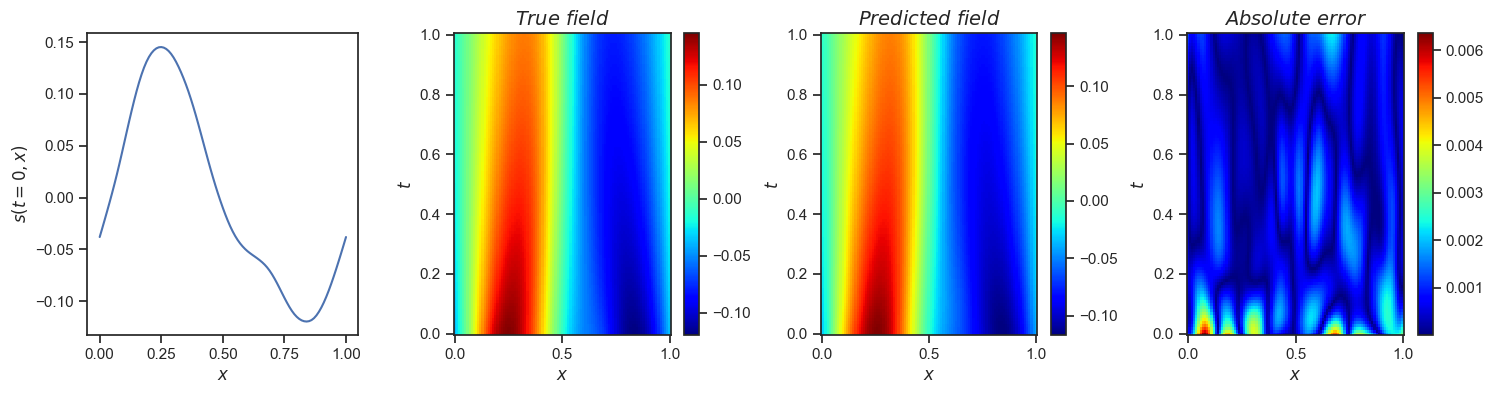

######################################################################################################################################################################################################################################
TEST SAMPLE 280
Rel. L2 Error = 0.0113, R2 score = 0.9999


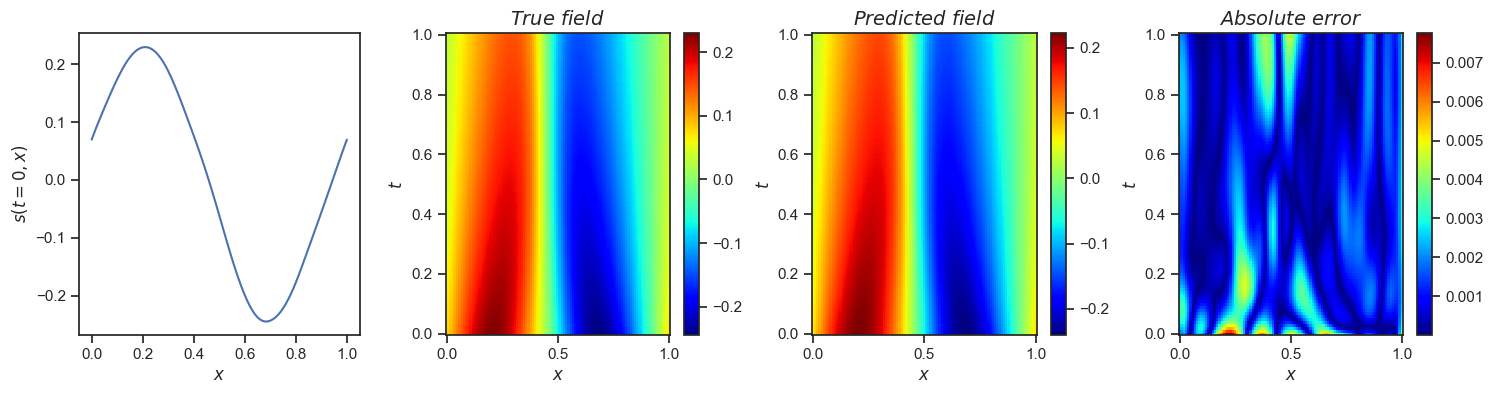

######################################################################################################################################################################################################################################
TEST SAMPLE 290
Rel. L2 Error = 0.012, R2 score = 0.9999


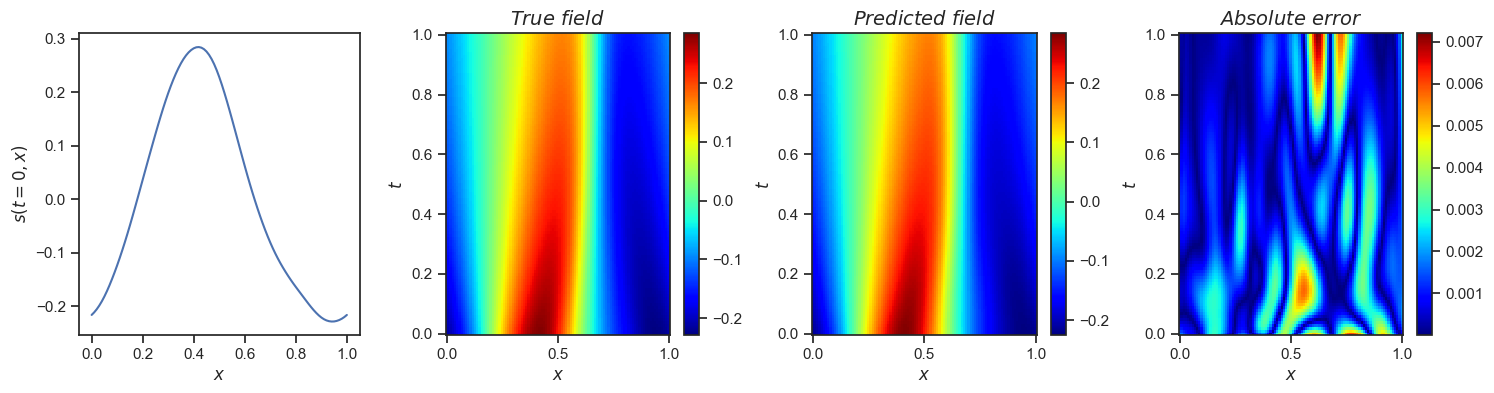

######################################################################################################################################################################################################################################
TEST SAMPLE 300
Rel. L2 Error = 0.0147, R2 score = 0.9998


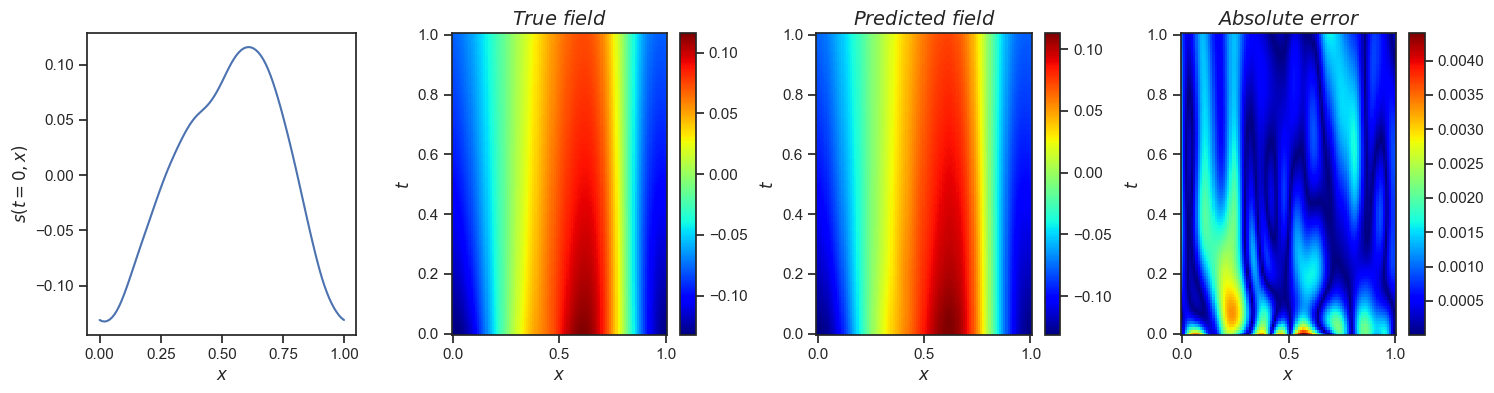

######################################################################################################################################################################################################################################
TEST SAMPLE 310
Rel. L2 Error = 0.0145, R2 score = 0.9998


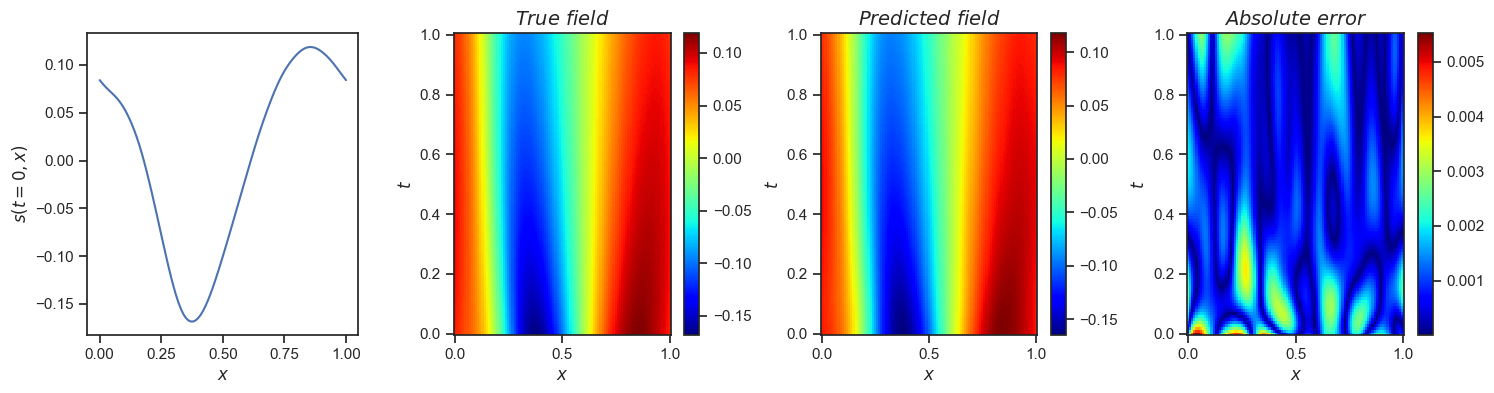

######################################################################################################################################################################################################################################
TEST SAMPLE 320
Rel. L2 Error = 0.0104, R2 score = 0.9999


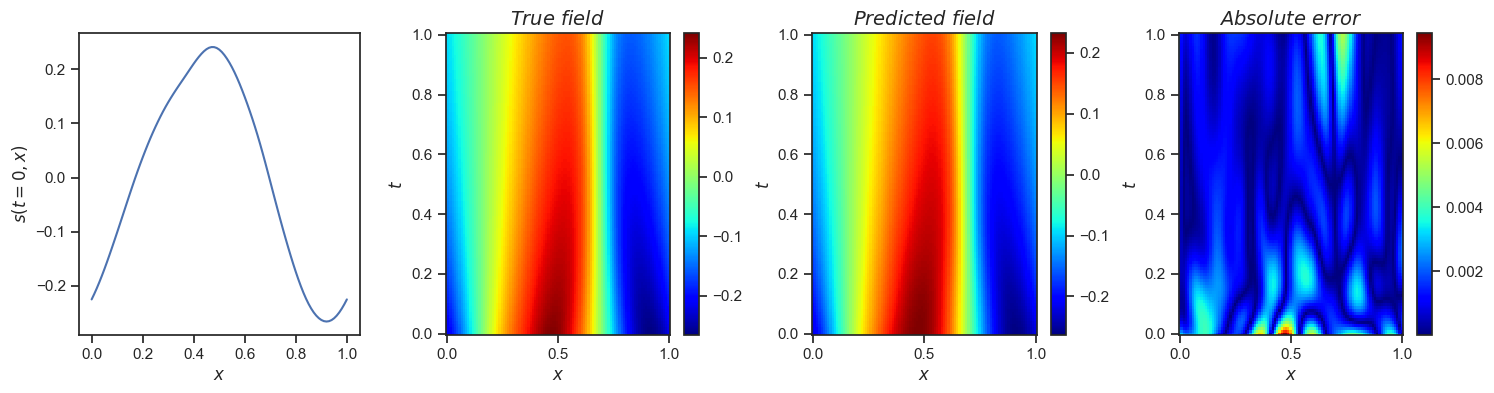

######################################################################################################################################################################################################################################
TEST SAMPLE 330
Rel. L2 Error = 0.0203, R2 score = 0.9996


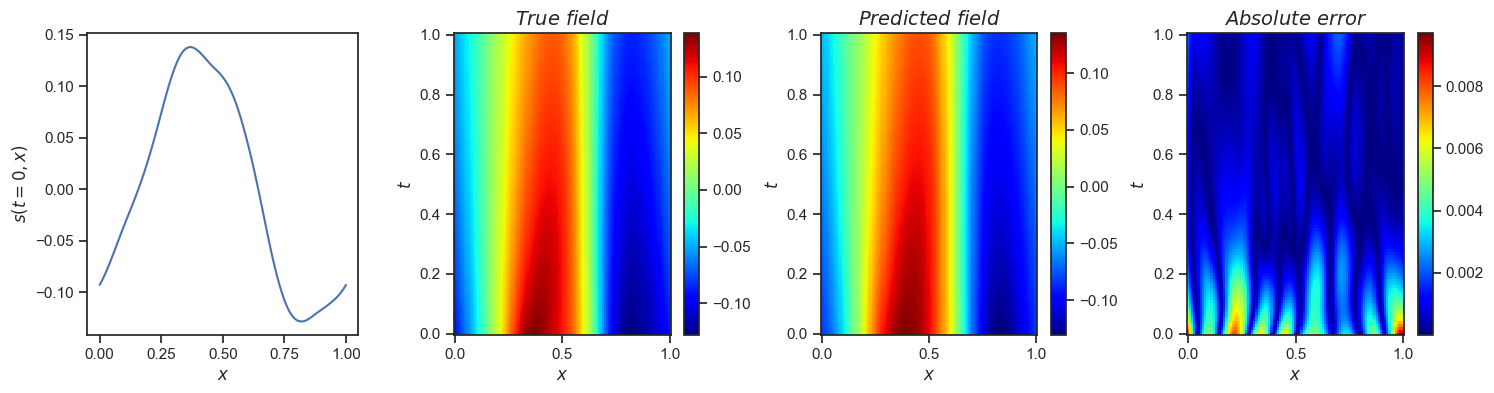

######################################################################################################################################################################################################################################
TEST SAMPLE 340
Rel. L2 Error = 0.011, R2 score = 0.9999


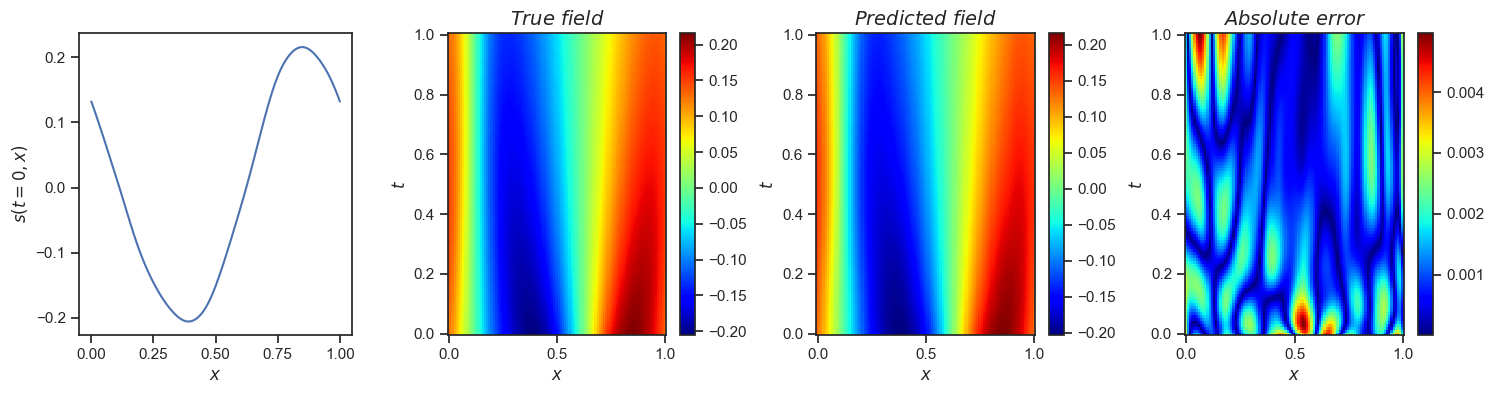

######################################################################################################################################################################################################################################
TEST SAMPLE 350
Rel. L2 Error = 0.016, R2 score = 0.9997


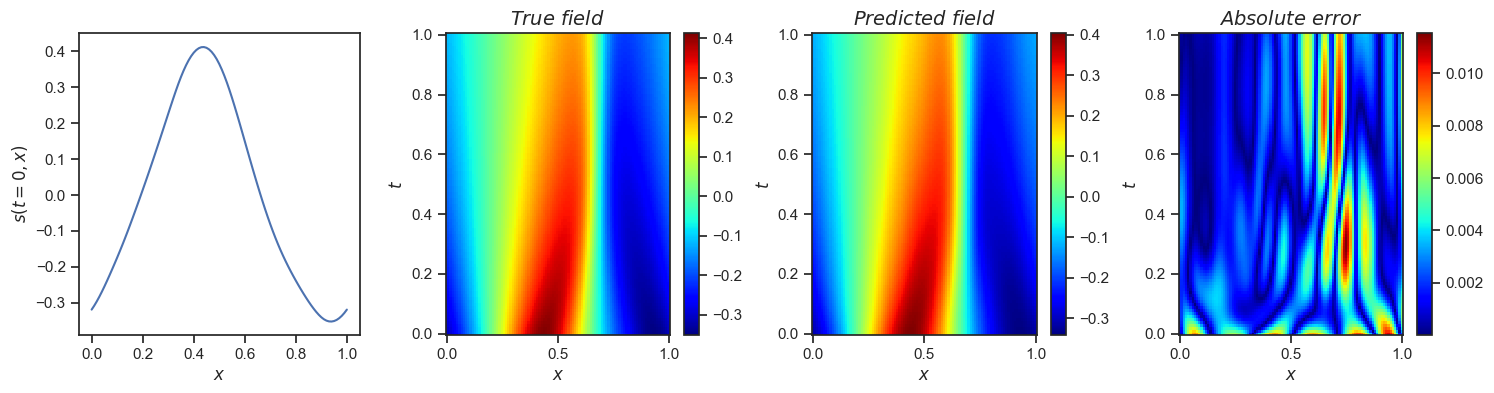

######################################################################################################################################################################################################################################
TEST SAMPLE 360
Rel. L2 Error = 0.0097, R2 score = 0.9999


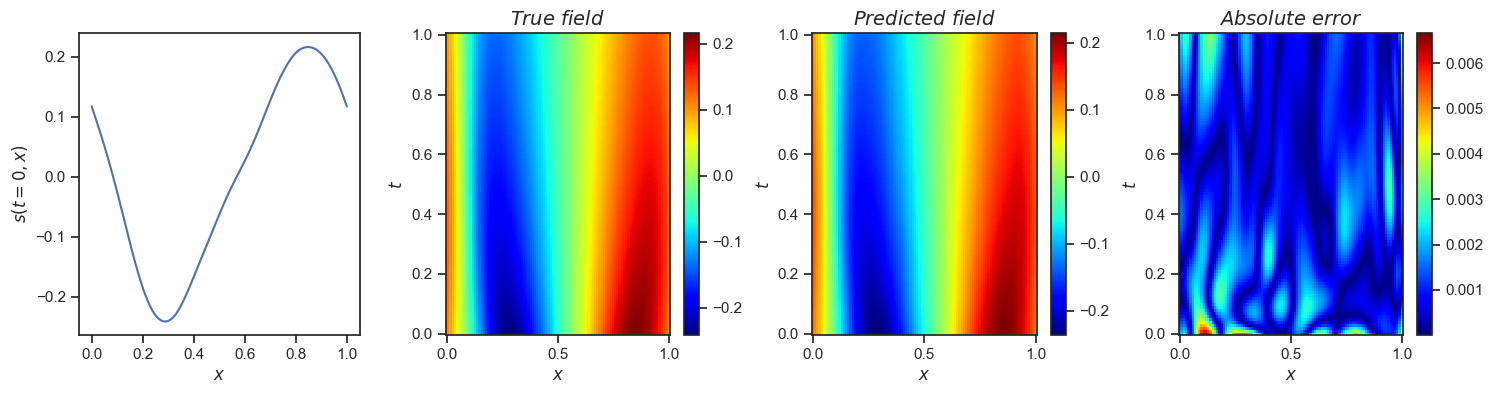

######################################################################################################################################################################################################################################
TEST SAMPLE 370
Rel. L2 Error = 0.0306, R2 score = 0.9991


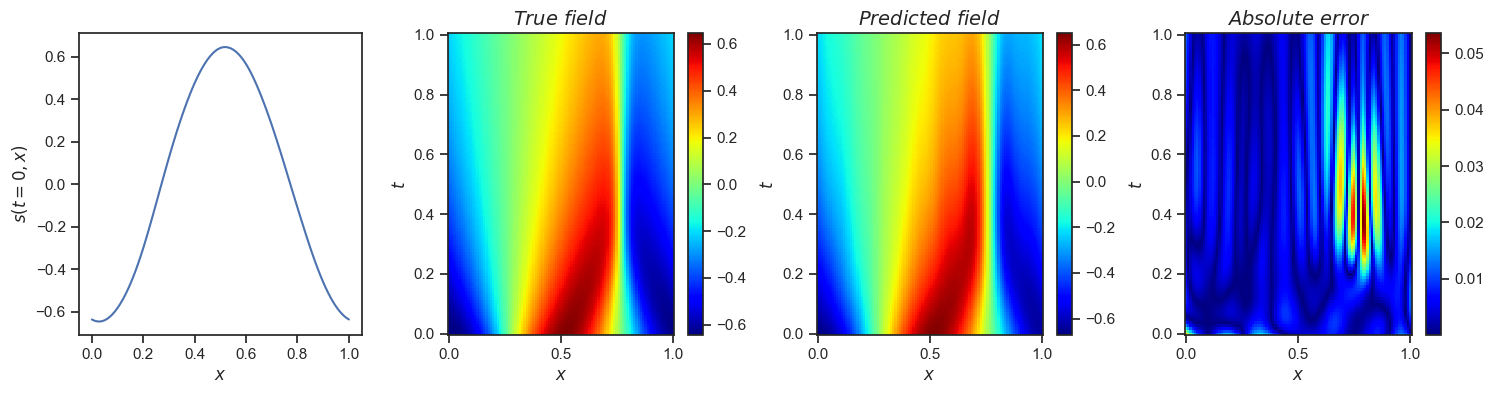

######################################################################################################################################################################################################################################
TEST SAMPLE 380
Rel. L2 Error = 0.0114, R2 score = 0.9999


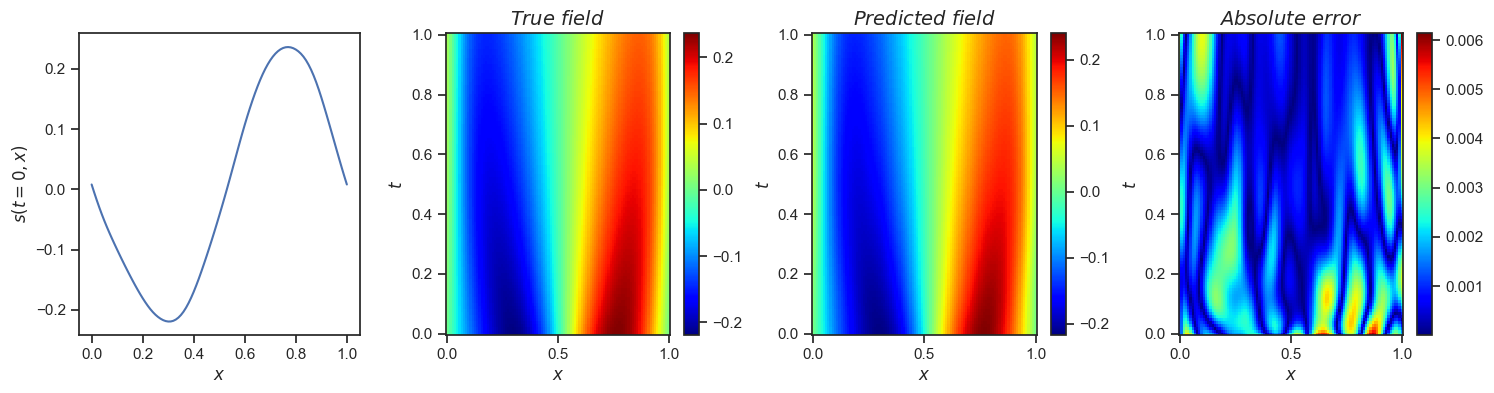

######################################################################################################################################################################################################################################
TEST SAMPLE 390
Rel. L2 Error = 0.0203, R2 score = 0.9996


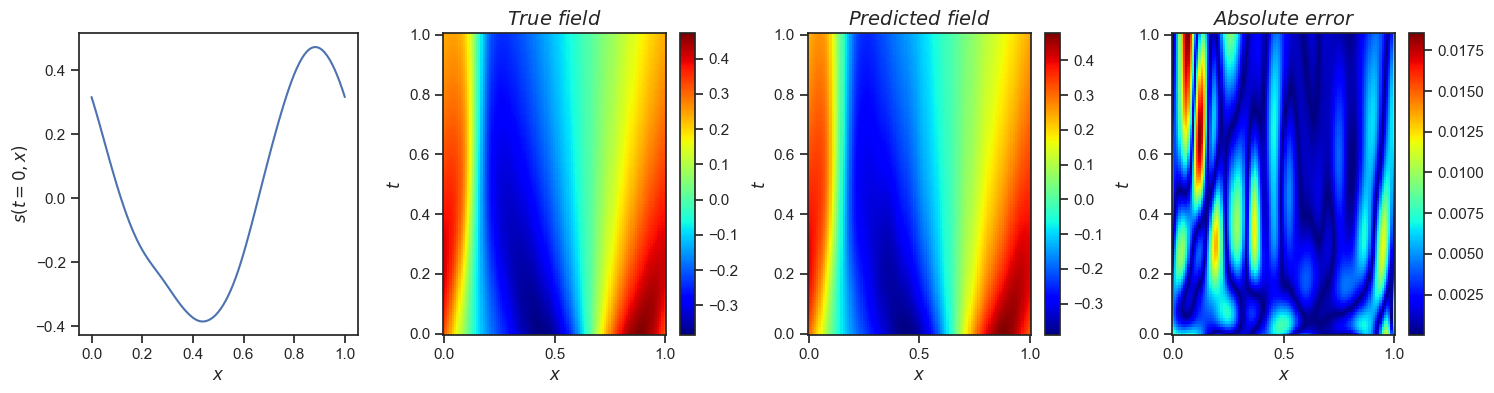

######################################################################################################################################################################################################################################
TEST SAMPLE 400
Rel. L2 Error = 0.0131, R2 score = 0.9998


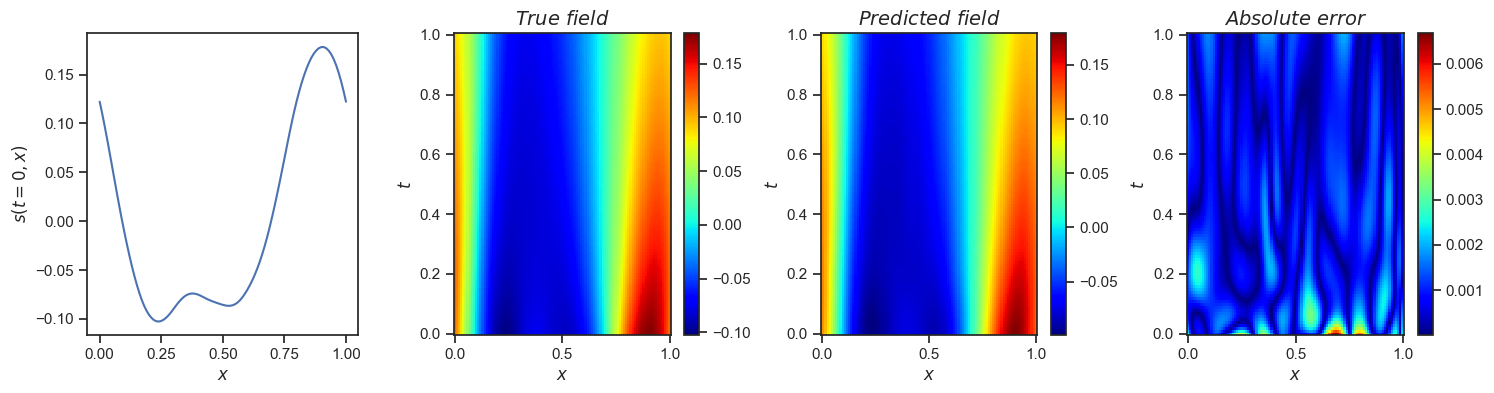

######################################################################################################################################################################################################################################
TEST SAMPLE 410
Rel. L2 Error = 0.0136, R2 score = 0.9998


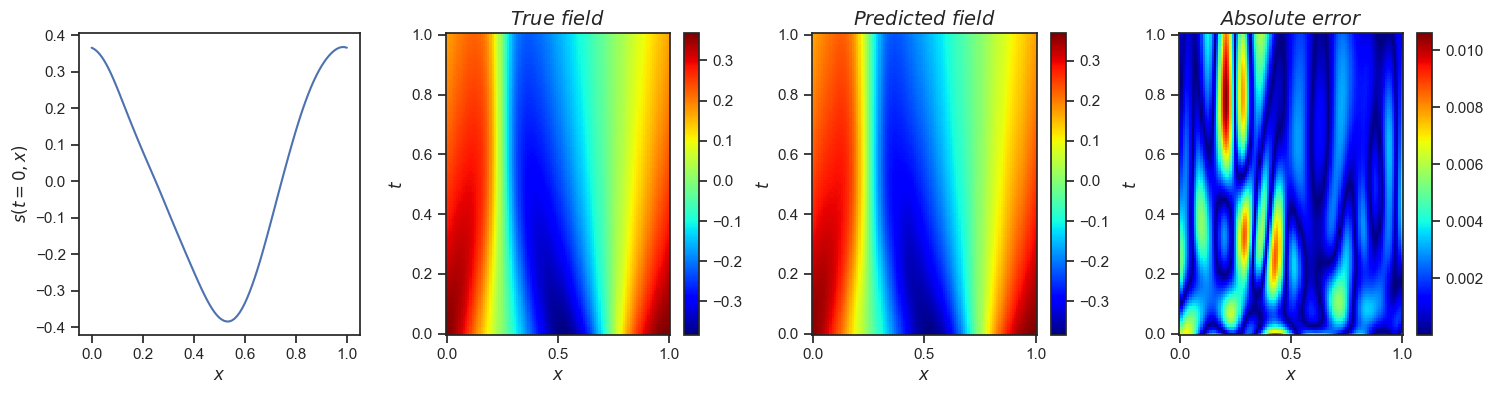

######################################################################################################################################################################################################################################
TEST SAMPLE 420
Rel. L2 Error = 0.01, R2 score = 0.9999


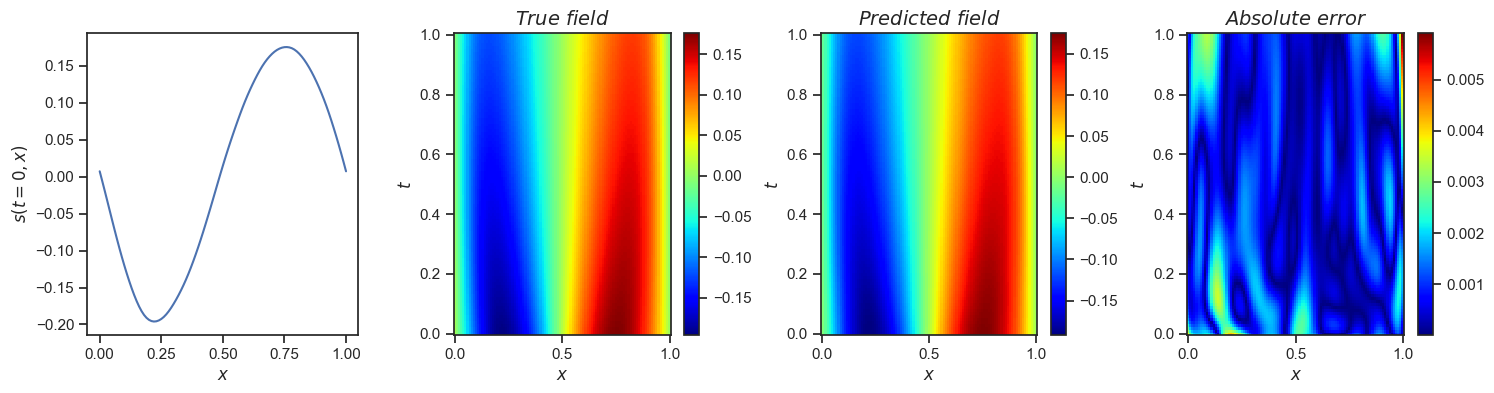

######################################################################################################################################################################################################################################
TEST SAMPLE 430
Rel. L2 Error = 0.012, R2 score = 0.9999


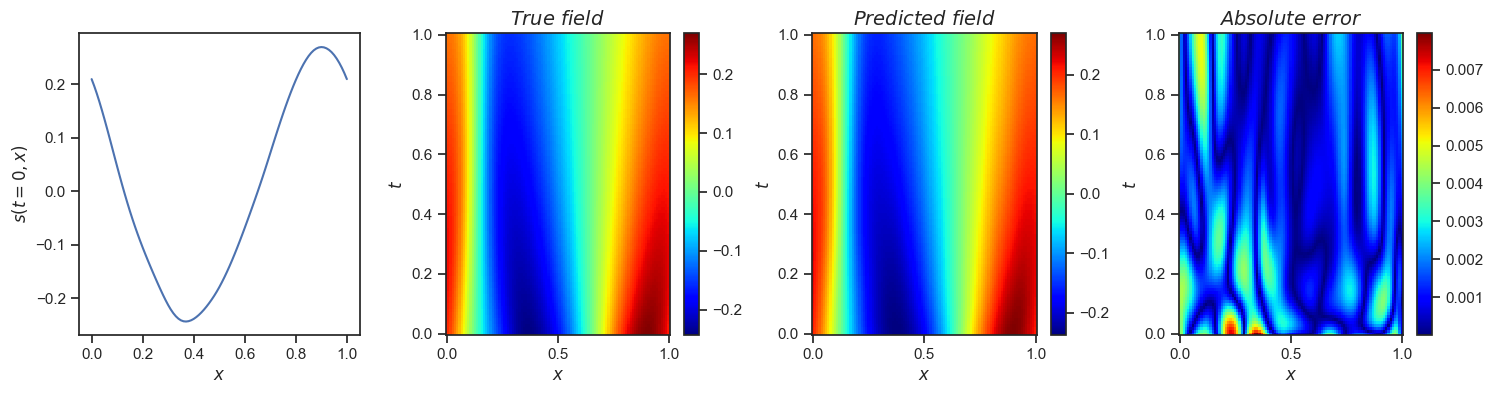

######################################################################################################################################################################################################################################
TEST SAMPLE 440
Rel. L2 Error = 0.0102, R2 score = 0.9999


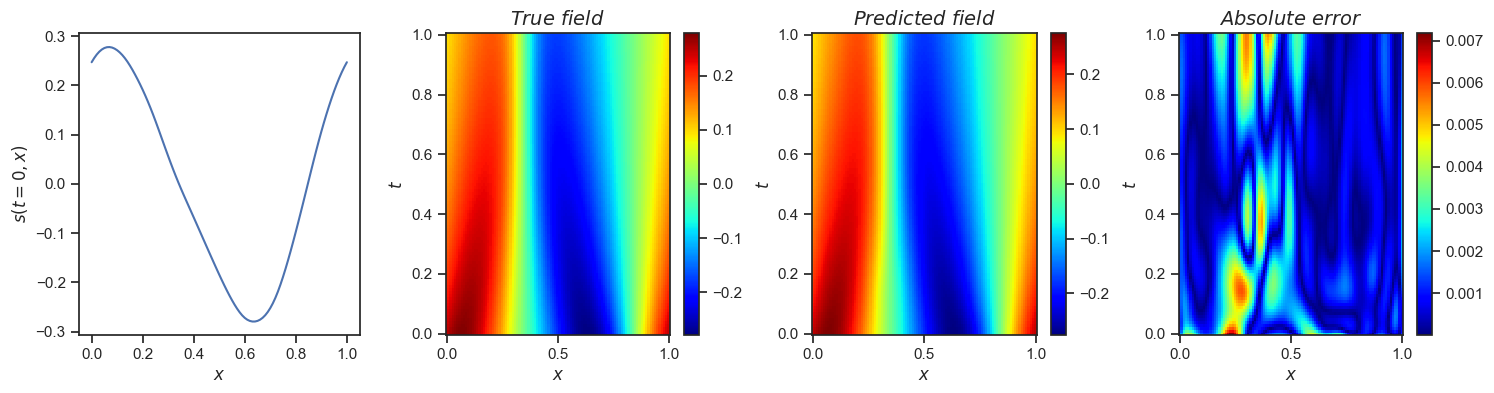

######################################################################################################################################################################################################################################
TEST SAMPLE 450
Rel. L2 Error = 0.0193, R2 score = 0.9996


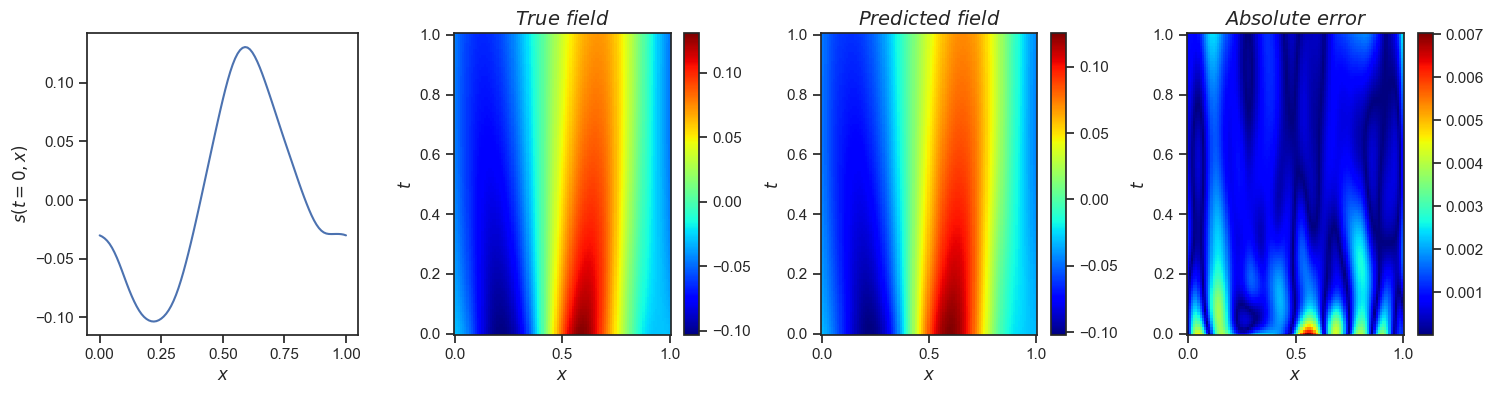

######################################################################################################################################################################################################################################
TEST SAMPLE 460
Rel. L2 Error = 0.02, R2 score = 0.9996


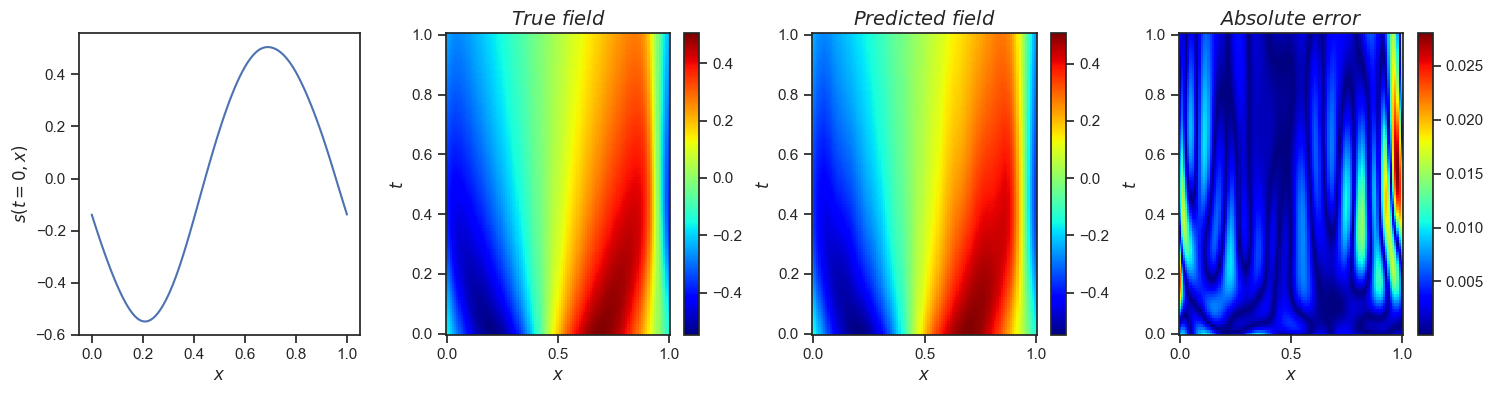

######################################################################################################################################################################################################################################
TEST SAMPLE 470
Rel. L2 Error = 0.013, R2 score = 0.9998


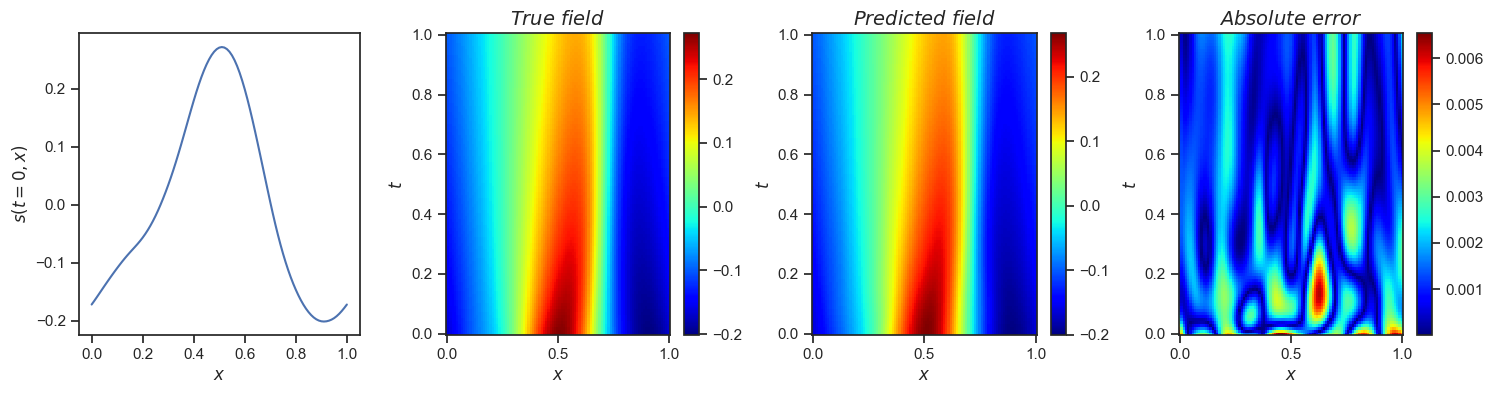

######################################################################################################################################################################################################################################
TEST SAMPLE 480
Rel. L2 Error = 0.0238, R2 score = 0.9994


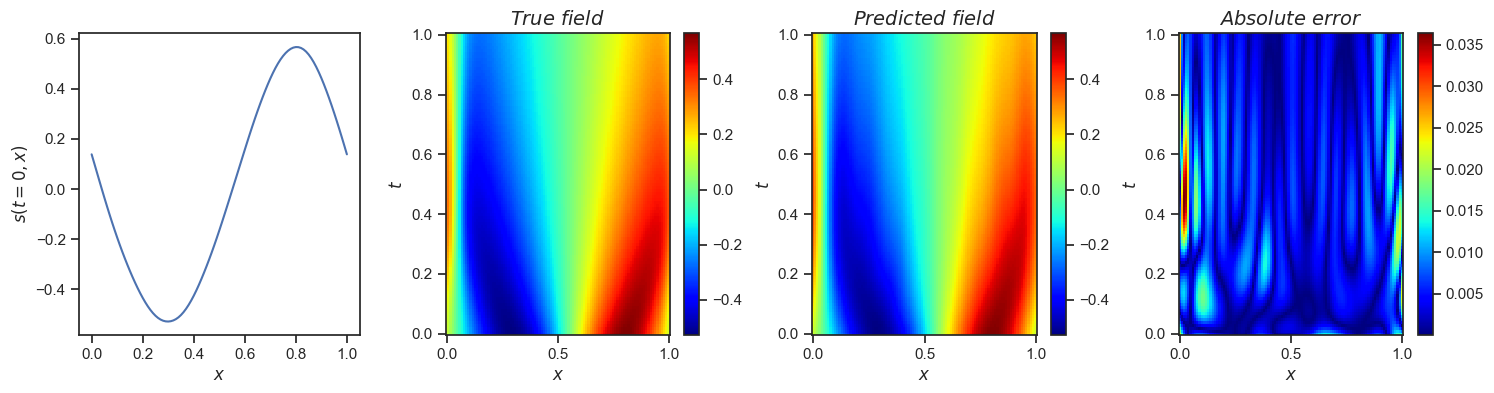

######################################################################################################################################################################################################################################
TEST SAMPLE 490
Rel. L2 Error = 0.0134, R2 score = 0.9998


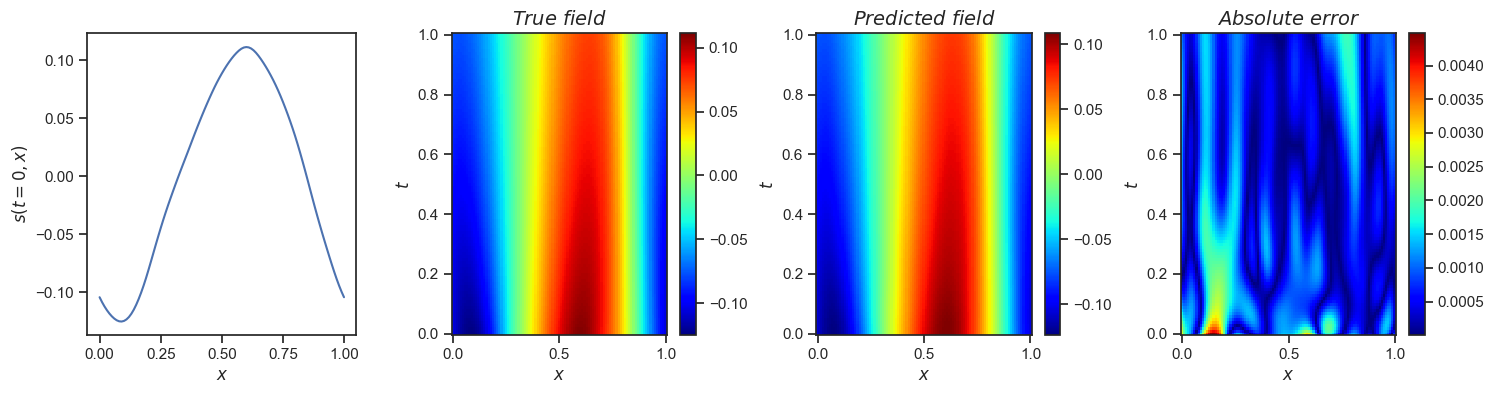

######################################################################################################################################################################################################################################
TEST SAMPLE 500
Rel. L2 Error = 0.0107, R2 score = 0.9999


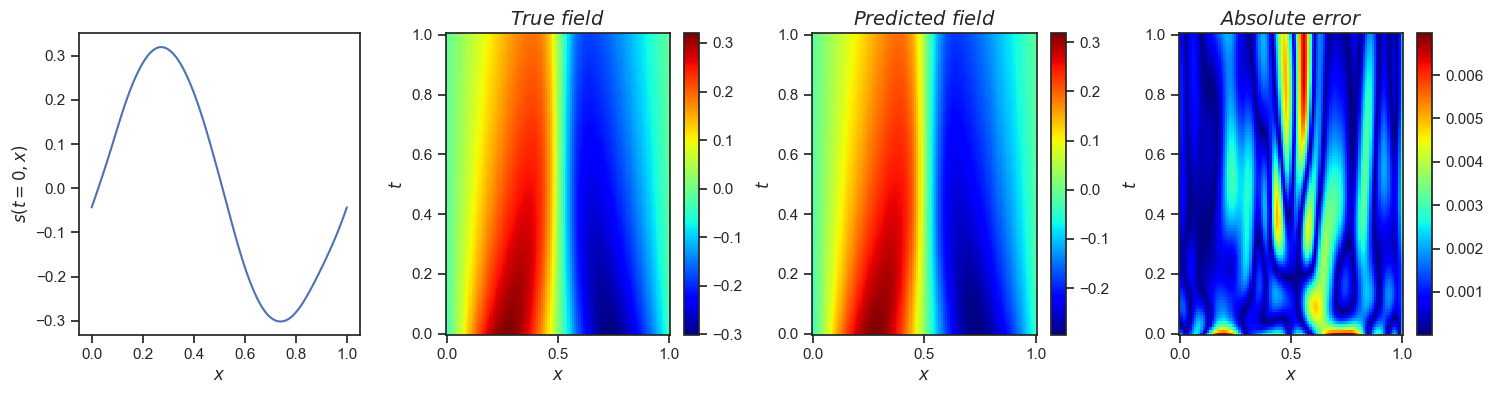

######################################################################################################################################################################################################################################
Mean Squared Error Test:
 1.020958977784403e-05


In [ ]:
# Predictions
mse_list = []

for i in range(inputs_test.shape[0]):
    
    branch_inputs = inputs_test[i].reshape(1, nx) # (bs, m) = (1, nx) 
    trunk_inputs = grid # (neval, 2) = (nt*nx, 2)

    prediction_i = model(branch_inputs, trunk_inputs).cpu() # (bs, neval) = (1, nt*nx)
    target_i = outputs_test[i].reshape(1, -1).cpu()
    mse_i = F.mse_loss(prediction_i, target_i)
    mse_list.append(mse_i.item())
    

    if (i+1) % 10 == 0:
        print(colored('TEST SAMPLE '+str(i+1), 'red'))
        
        r2score = metrics.r2_score(outputs_test[i].flatten().cpu().detach().numpy(), prediction_i.flatten().cpu().detach().numpy()) 
        relerror = np.linalg.norm(outputs_test[i].flatten().cpu().detach().numpy() - prediction_i.flatten().cpu().detach().numpy()) / np.linalg.norm(outputs_test[i].flatten().cpu().detach().numpy())
        r2score = float('%.4f'%r2score)
        relerror = float('%.4f'%relerror)
        print('Rel. L2 Error = '+str(relerror)+', R2 score = '+str(r2score))
        
        fig = plt.figure(figsize=(15,4))
        plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.9, top = 0.5, wspace = 0.4, hspace = 0.1)
        
        ax = fig.add_subplot(1, 4, 1)    
        ax.plot(x_span.cpu().detach().numpy(), inputs_test[i].cpu().detach().numpy())
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$s(t=0, x)$')
        plt.tight_layout()
        
        ax = fig.add_subplot(1, 4, 2)  
        plt.pcolor(X.cpu().detach().numpy(), T.cpu().detach().numpy(), outputs_test[i].cpu().detach().numpy(), cmap='jet')
        plt.colorbar()
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$t$')
        plt.title('$True \ field$',fontsize=14)
        plt.tight_layout()

        ax = fig.add_subplot(1, 4, 3)  
        plt.pcolor(X.cpu().detach().numpy(), T.cpu().detach().numpy(), prediction_i.reshape(nt, nx).cpu().detach().numpy(), cmap='jet')
        plt.colorbar()
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$t$')
        plt.title('$Predicted \ field$',fontsize=14)  
        plt.tight_layout()
        
        ax = fig.add_subplot(1, 4, 4)  
        plt.pcolor(X.cpu().detach().numpy(), T.cpu().detach().numpy(), np.abs(outputs_test[i].cpu().detach().numpy() - prediction_i.reshape(nt, nx).cpu().detach().numpy()), cmap='jet')
        plt.colorbar()
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$t$')
        plt.title('$Absolute \ error$',fontsize=14)  
        plt.tight_layout()

        if save == True:
            plt.savefig(os.path.join(resultdir,'Test_Sample_'+str(i+1)+'.pdf'))
            plt.show()
            plt.close()
        if save == False:
            plt.show()

        print(colored('#'*230, 'green'))

mse = sum(mse_list) / len(mse_list)
print("Mean Squared Error Test:\n", mse)

In [ ]:
print("Time (sec) to complete:\n" +str(finish)) # time for network to train
if save == True and cluster == True:
    print ("------END------")
    sys.stdout = orig_stdout
    q.close()

Time (sec) to complete:
573.5485818386078
